- data: 건물 100개의 시간대별 전력사용량 (2022/06/01 00 ~ 2022/08/24)
- 출처: 데이콘

- train: 2022/06/01 ~ 2022/08/17
- test:  2022/08/18 ~ 2022/08/24
- covariates 최대한 활용
- 공변량 사용한 in-depth 데이터는 지식산업센터로
- 전처리: 데이콘 리더보드 참고
- Auto.Arima (R)과 성능 비교
- Develop

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Installation

In [ ]:
!pip install holidays

In [ ]:
!pip install autogluon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.5/308.5 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.5/427.5 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.1/147.1 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 73.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 96.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

# Data & Libraries Import

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import statsmodels.api as sm
import holidays

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TS/train.csv")
data.head()

num_date_time  건물번호           일시  기온(C)  강수량(mm)  풍속(m/s)  습도(%)  일조(hr)  \
0  1_20220601 00     1  20220601 00   18.6      NaN      0.9   42.0     NaN   
1  1_20220601 01     1  20220601 01   18.0      NaN      1.1   45.0     NaN   
2  1_20220601 02     1  20220601 02   17.7      NaN      1.5   45.0     NaN   
3  1_20220601 03     1  20220601 03   16.7      NaN      1.4   48.0     NaN   
4  1_20220601 04     1  20220601 04   18.4      NaN      2.8   43.0     NaN   

   일사(MJ/m2)  전력소비량(kWh)  
0        NaN     1085.28  
1        NaN     1047.36  
2        NaN      974.88  
3        NaN      953.76  
4        NaN      986.40

# Model 1 - Random 10 MSPE


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TS/train2.csv")
data.head(2)

item_id    timestamp   target
0        1  20220601 00  1085.28
1        1  20220601 01  1047.36

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   item_id    204000 non-null  int64  
 1   timestamp  204000 non-null  object 
 2   target     204000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 4.7+ MB


In [ ]:
def convert_to_datetime(timestamp_str):
    return pd.to_datetime(timestamp_str, format='%Y%m%d %H', errors='coerce')

# apply() 메서드를 사용하여 변환 함수를 각 행에 적용
data['timestamp'] = data['timestamp'].apply(convert_to_datetime)

data.head()

item_id           timestamp   target
0        1 2022-06-01 00:00:00  1085.28
1        1 2022-06-01 01:00:00  1047.36
2        1 2022-06-01 02:00:00   974.88
3        1 2022-06-01 03:00:00   953.76
4        1 2022-06-01 04:00:00   986.40

In [ ]:
data10 = data[data['item_id'].isin([10, 20, 30, 40, 50, 60, 71, 80, 90, 100])]

data10_eda = data10[data10['timestamp'] <= '2022-08-17 23:00:00']

## rdm10 EDA

In [ ]:
data10_eda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18720 entries, 18360 to 203831
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   item_id    18720 non-null  int64         
 1   timestamp  18720 non-null  datetime64[ns]
 2   target     18720 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 585.0 KB


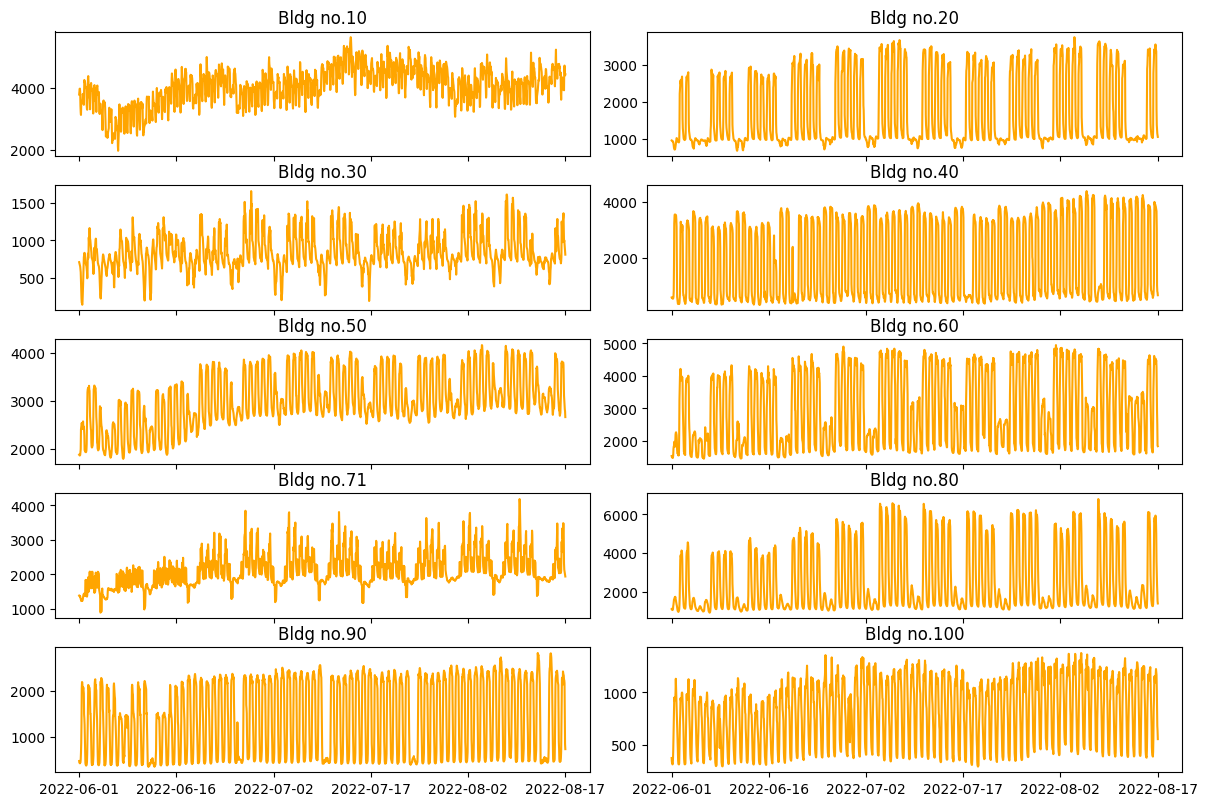

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 8), sharex=True)

# 플롯 간 간격을 조정합니다.
fig.tight_layout()

# 각 item_id에 대해 서브플롯을 그립니다.
item_ids = [10, 20, 30, 40, 50, 60, 71, 80, 90, 100]
axes = axes.flatten()  # 2D 배열을 1D 배열로 변환합니다.

for ax, item_id in zip(axes, item_ids):
    subset = data10_eda[data10_eda['item_id'] == item_id]
    ax.plot(subset['timestamp'], subset['target'], color='orange', label=f'Bldg no.{item_id}')
    ax.set_title(f'Bldg no.{item_id}')
    ax.set_xlabel('')  # x축 레이블 설정

    # x축 레이블을 5개만 표시
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    # x축 레이블 텍스트 설정
    ax.set_xticks(subset['timestamp'][::max(1, len(subset) // 5)])  # 데이터 개수에 따라 레이블을 5개로 제한


plt.show()

ACF, PACF

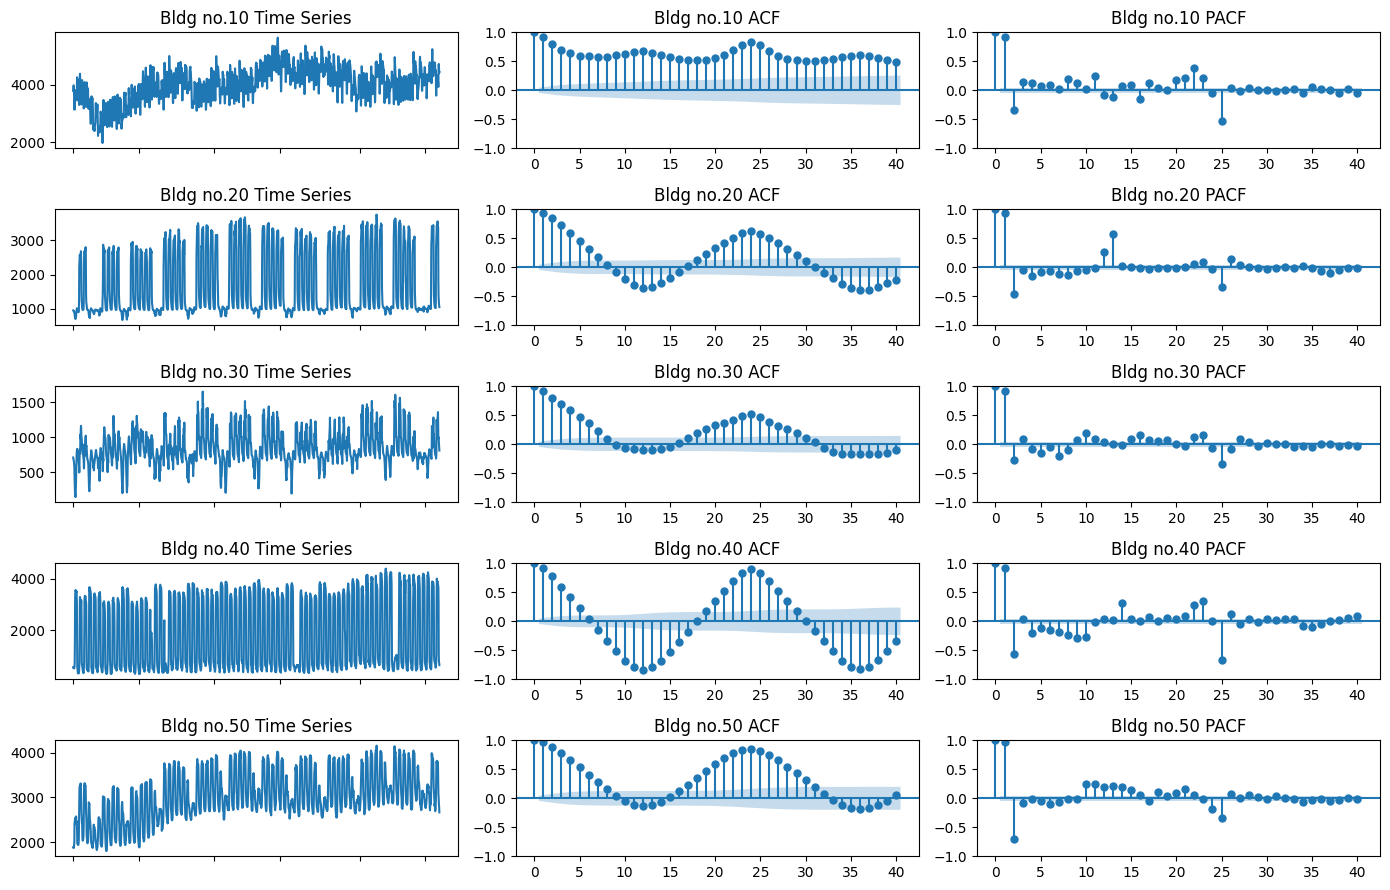

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(14, 9))

item_ids = [10, 20, 30, 40, 50]

for i, item_id in enumerate(item_ids):
    subset = data10_eda[data10_eda['item_id'] == item_id]

    # 시계열 플롯
    axes[i, 0].plot(subset['timestamp'], subset['target'])
    axes[i, 0].set_title(f'Bldg no.{item_id} Time Series')
    axes[i, 0].set_xlabel('')
    axes[i, 0].set_ylabel('')
    axes[i, 0].set_xticklabels([])

    # ACF 플롯
    sm.graphics.tsa.plot_acf(subset['target'], lags=40, ax=axes[i, 1])
    axes[i, 1].set_title(f'Bldg no.{item_id} ACF')

    # PACF 플롯
    sm.graphics.tsa.plot_pacf(subset['target'], lags=40, ax=axes[i, 2])
    axes[i, 2].set_title(f'Bldg no.{item_id} PACF')

plt.tight_layout()
plt.show()

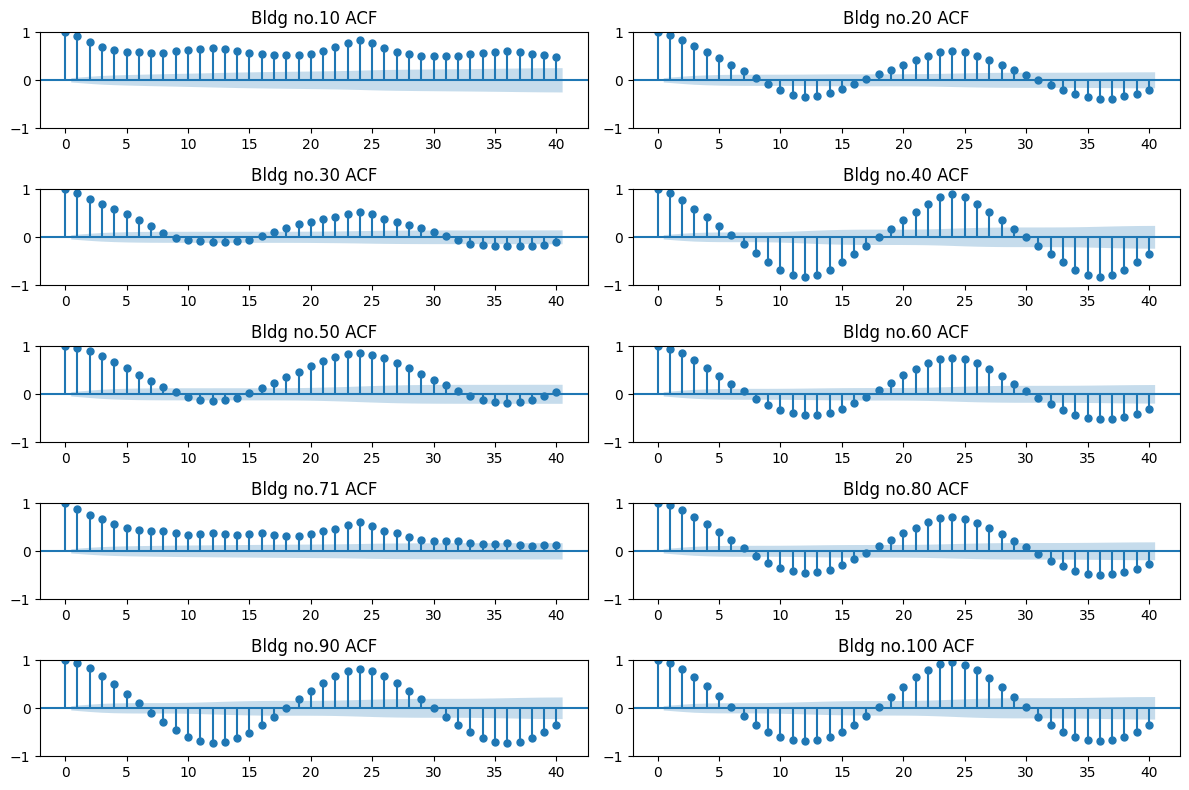

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 8))

item_ids = [10, 20, 30, 40, 50, 60, 71, 80, 90, 100]

for i, item_id in enumerate(item_ids):
    row = i // 2
    col = i % 2
    subset = data10_eda[data10_eda['item_id'] == item_id]

    # ACF 플롯
    sm.graphics.tsa.plot_acf(subset['target'], lags=40, ax=axes[row, col])
    axes[row, col].set_title(f'Bldg no.{item_id} ACF')

plt.tight_layout()
plt.show()

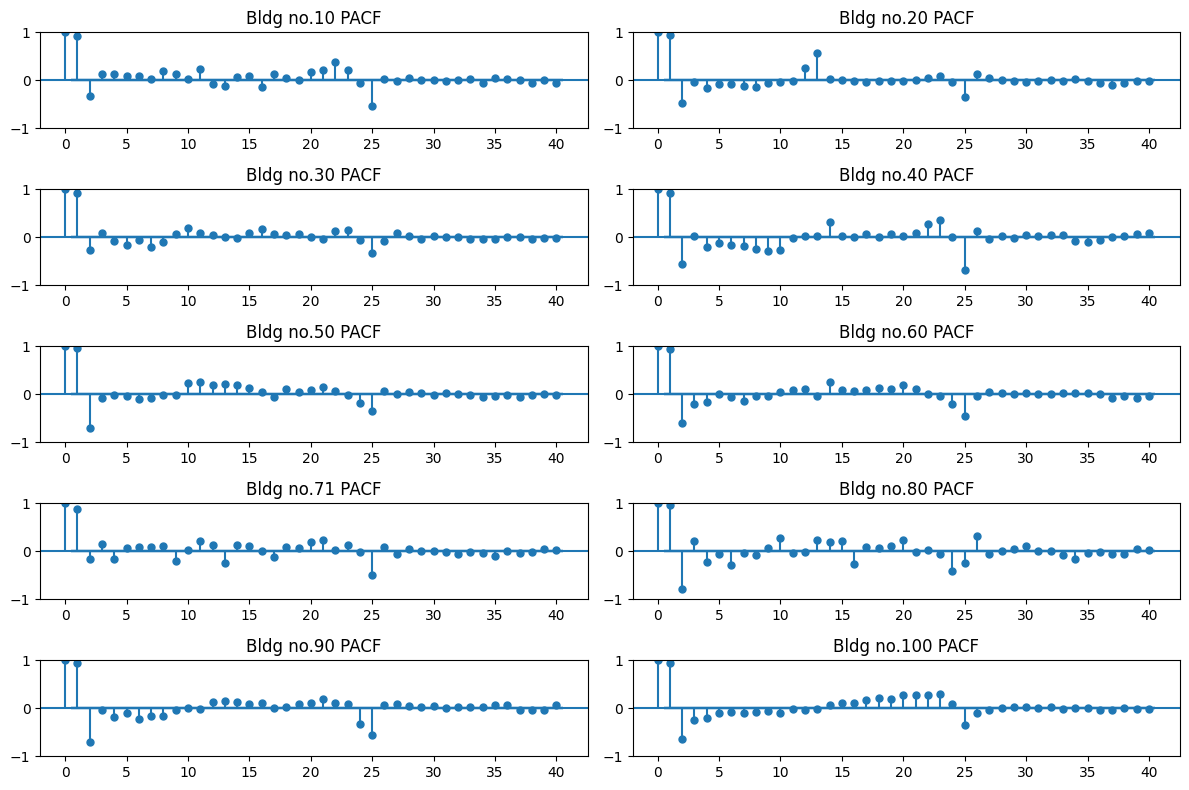

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 8))

item_ids = [10, 20, 30, 40, 50, 60, 71, 80, 90, 100]

for i, item_id in enumerate(item_ids):
    row = i // 2
    col = i % 2
    subset = data10_eda[data10_eda['item_id'] == item_id]

    # PACF 플롯
    sm.graphics.tsa.plot_pacf(subset['target'], lags=40, ax=axes[row, col])
    axes[row, col].set_title(f'Bldg no.{item_id} PACF')

plt.tight_layout()

## Modeling

In [ ]:
data10_train = data10[data10['timestamp'] <= '2022-08-17 23:00:00']
data10_test = data10[data10['timestamp'] >= '2022-08-18 0:00:00']

In [ ]:
# Model for 2 buildings

print(data10.shape)
print("Train 데이터")
print(data10_train)
print("\nTest 데이터")
print(data10_test)

(20400, 3)
Train 데이터
        item_id           timestamp   target
18360        10 2022-06-01 00:00:00  3785.76
18361        10 2022-06-01 01:00:00  3867.84
18362        10 2022-06-01 02:00:00  3972.48
18363        10 2022-06-01 03:00:00  3976.80
18364        10 2022-06-01 04:00:00  3855.36
...         ...                 ...      ...
203827      100 2022-08-17 19:00:00  1049.52
203828      100 2022-08-17 20:00:00   874.32
203829      100 2022-08-17 21:00:00   678.24
203830      100 2022-08-17 22:00:00   632.64
203831      100 2022-08-17 23:00:00   552.72

[18720 rows x 3 columns]

Test 데이터
        item_id           timestamp   target
20232        10 2022-08-18 00:00:00  4493.28
20233        10 2022-08-18 01:00:00  4450.08
20234        10 2022-08-18 02:00:00  4341.60
20235        10 2022-08-18 03:00:00  4204.32
20236        10 2022-08-18 04:00:00  4143.36
...         ...                 ...      ...
203995      100 2022-08-24 19:00:00   881.04
203996      100 2022-08-24 20:00:00   798.9

In [ ]:
train = TimeSeriesDataFrame(data10_train)

In [ ]:
predictor = TimeSeriesPredictor(
    prediction_length = 168,
    path = "autogluon-energy-10-3600",
    target = "target",
    eval_metric = "MSE"
)

predictor.fit(
    train,
    presets = "high_quality",
    time_limit = 3600
)

Beginning AutoGluon training... Time limit = 3600s
AutoGluon will save models to 'autogluon-energy-10-3600'
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Apr 28 14:29:16 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       9.92 GB / 12.67 GB (78.3%)
Disk Space Avail:   74.06 GB / 107.72 GB (68.8%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 168,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit': 3600,
 'verbosity': 2}

Inferred time series frequency: 'H'
Provided train_data has 18720 rows, 1

In [ ]:
predictions = predictor.predict(train)
predictions.head()

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean          0.1          0.2  \
item_id timestamp                                                    
10      2022-08-18 00:00:00  4408.133778  4084.585452  4190.977310   
        2022-08-18 01:00:00  4406.646776  3925.437396  4109.343101   
        2022-08-18 02:00:00  4351.803505  3845.770218  4024.769351   
        2022-08-18 03:00:00  4348.428530  3828.029430  4010.273853   
        2022-08-18 04:00:00  4289.556609  3707.089864  3935.451449   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
10      2022-08-18 00:00:00  4254.310086  4323.605603  4400.397685   
        2022-08-18 01:00:00  4225.027954  4311.958049  4383.062393   
        2022-08-18 02:00:00  4179.341743  4268.497912  4360.618753   
        2022-08-18 03:00:00  4122.991169  4233.538909  4338.818132   
        2022-08-18 04:00:00  4066.537914  4175.243220  4279.198073   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
10      2022-08-18 00:00:00  4482.475414  4571.004814  4651.369119   
        2022-08-18 01:00:00  4515.685795  4612.746713  4712.721449   
        2022-08-18 02:00:00  4450.830887  4588.438821  4697.495919   
        2022-08-18 03:00:00  4460.101120  4568.740154  4713.611823   
        2022-08-18 04:00:00  4385.208455  4535.171173  4694.007284   

                                     0.9  
item_id timestamp                         
10      2022-08-18 00:00:00  4752.768977  
        2022-08-18 01:00:00  4841.421507  
        2022-08-18 02:00:00  4838.027288  
        2022-08-18 03:00:00  4875.594599  
        2022-08-18 04:00:00  4885.809811

In [ ]:
predictions.tail()

mean         0.1         0.2         0.3  \
item_id timestamp                                                              
100     2022-08-24 19:00:00  1077.855579  314.838593  567.724168  762.880282   
        2022-08-24 20:00:00   986.360254  224.753350  494.596319  691.088792   
        2022-08-24 21:00:00   802.655611   37.432859  306.979239  498.419646   
        2022-08-24 22:00:00   705.308270  -57.602480  211.057817  405.373044   
        2022-08-24 23:00:00   606.559169 -151.133511  118.253583  311.184176   

                                    0.4          0.5          0.6  \
item_id timestamp                                                   
100     2022-08-24 19:00:00  919.099160  1085.736341  1230.937286   
        2022-08-24 20:00:00  853.045182   997.200239  1140.914826   
        2022-08-24 21:00:00  658.403945   812.743837   959.595728   
        2022-08-24 22:00:00  565.292603   708.673474   858.661403   
        2022-08-24 23:00:00  463.769888   607.202248   750.414372   

                                     0.7          0.8          0.9  
item_id timestamp                                                   
100     2022-08-24 19:00:00  1390.166047  1587.010632  1842.612442  
        2022-08-24 20:00:00  1296.998275  1475.945335  1737.639599  
        2022-08-24 21:00:00  1113.486851  1302.945140  1555.827049  
        2022-08-24 22:00:00  1012.781433  1199.608660  1452.412016  
        2022-08-24 23:00:00   911.075378  1093.141030  1360.105536

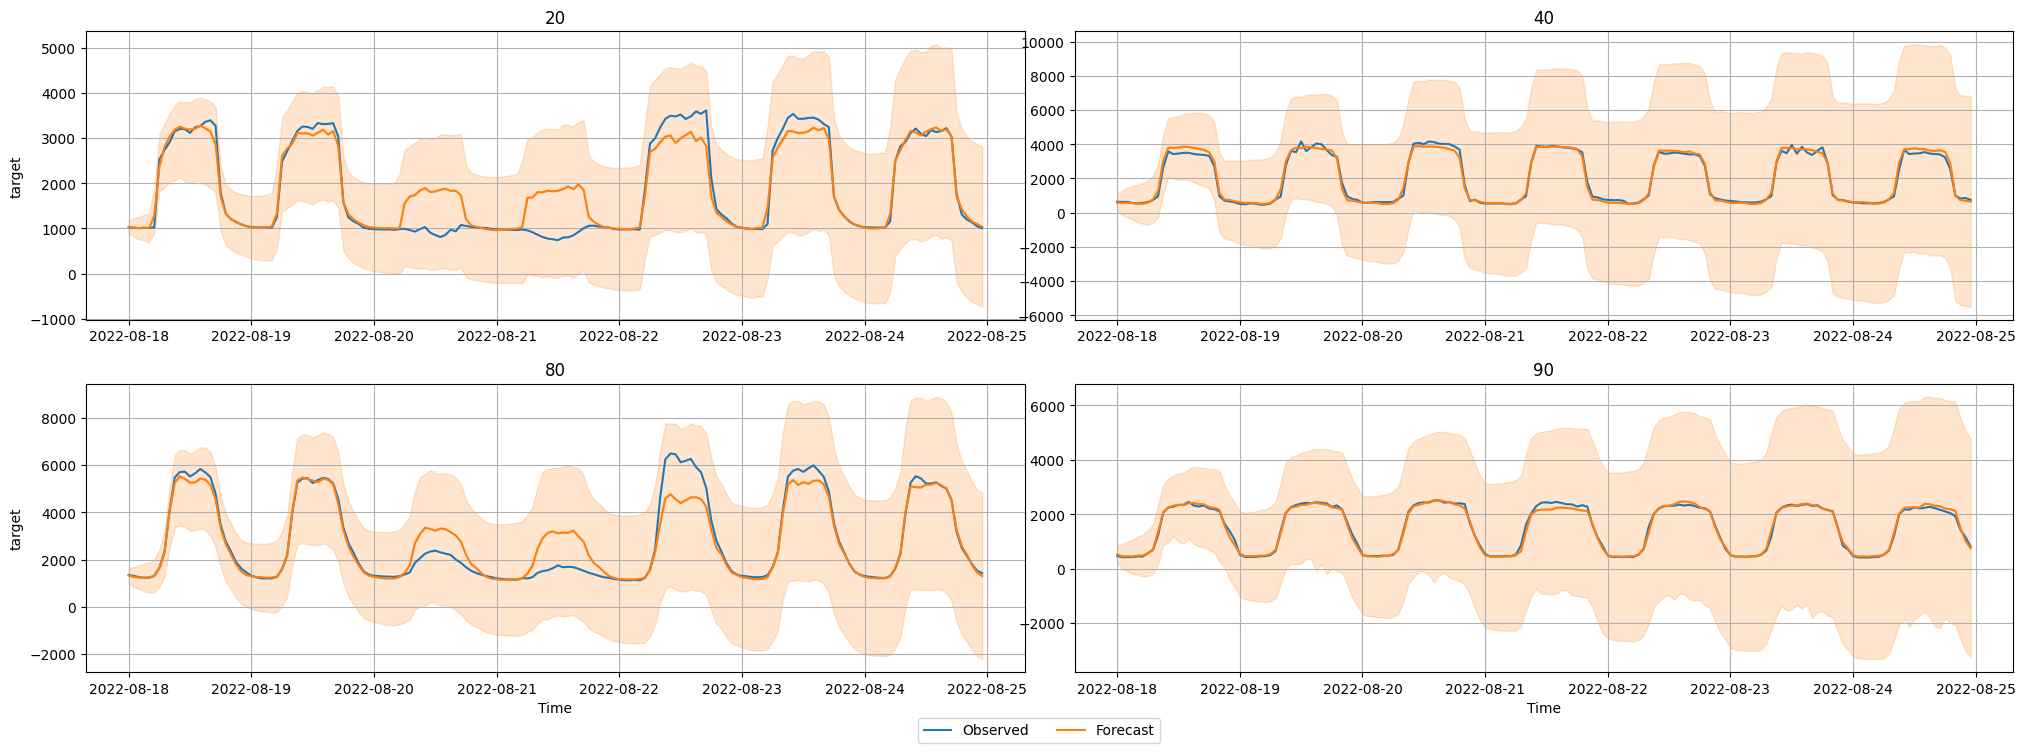

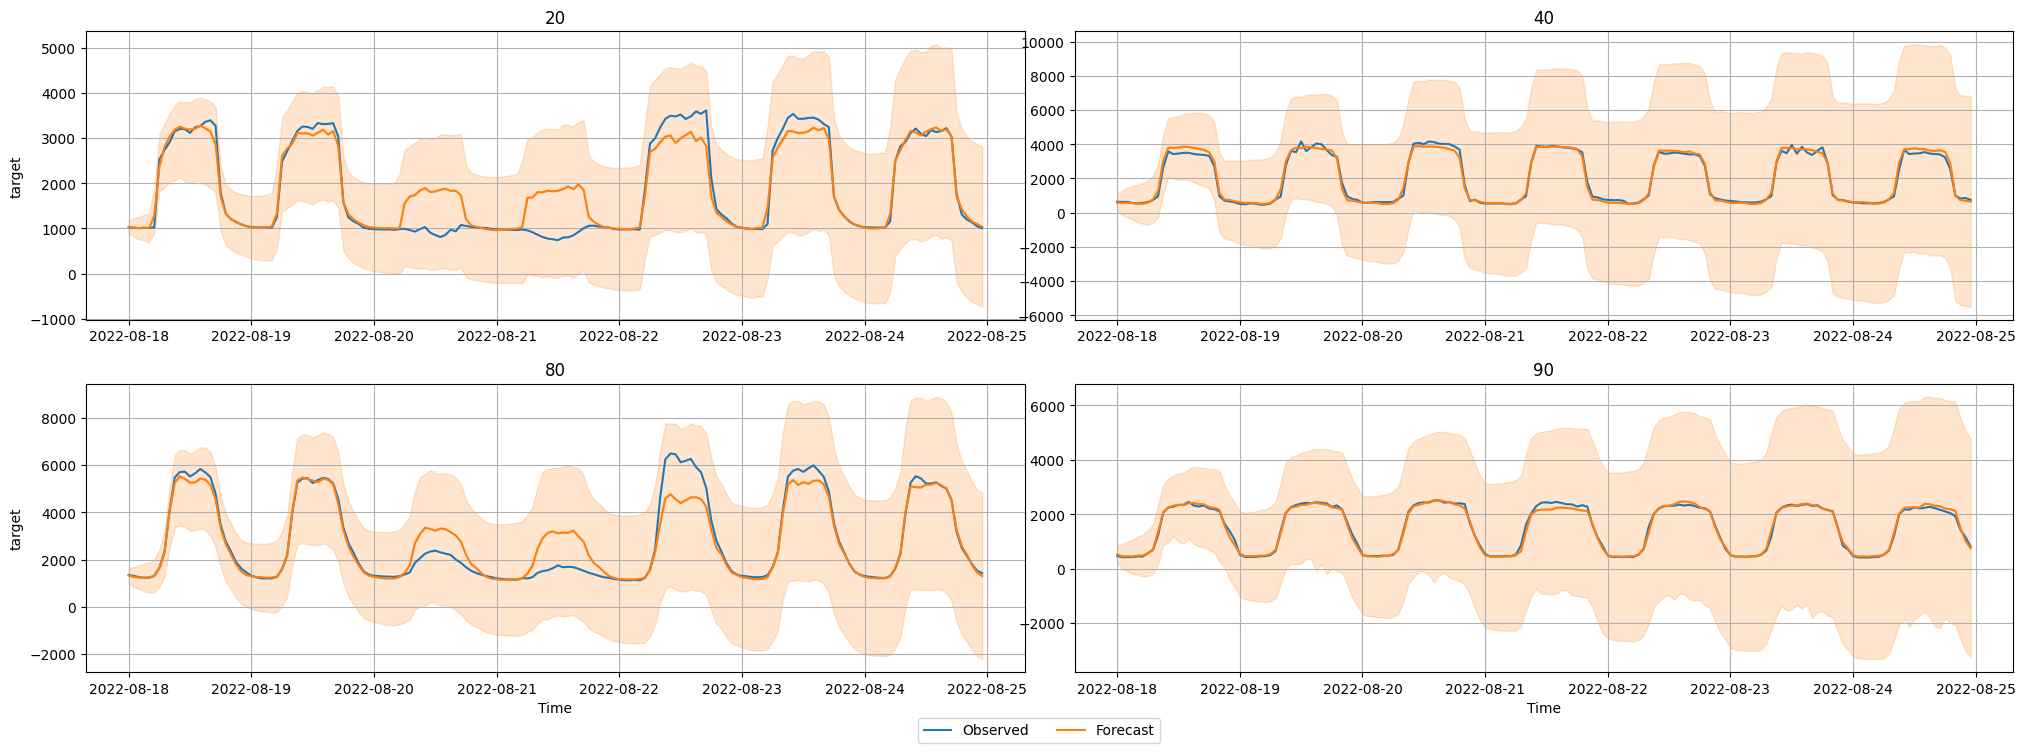

In [ ]:
test = TimeSeriesDataFrame(data10_test)

predictor.plot(test, predictions, quantile_levels=[0.1, 0.9], item_ids = [20, 40, 80, 90], max_num_item_ids = 4)

In [ ]:
predictor.model_best

'WeightedEnsemble'

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

# 실제 값과 예측 값을 추출하여 DataFrame 생성
actuals = data10_test[['item_id', 'timestamp', 'target']]
predicted = predictions.reset_index()[['item_id', 'timestamp', 'mean']]
merged_df = pd.merge(data10_test, predicted, on=['item_id', 'timestamp'])

# # MSPE 계산
merged_df['squared_error'] = (merged_df['target'] - merged_df['mean']) ** 2
mspe_value = np.mean(merged_df['squared_error'])

print(f"MSPE: {mspe_value}")

# MSPE를 CSV 파일로 저장
merged_df.to_csv('/content/drive/MyDrive/TimeSeries/mspe_rdm10.csv', index=False)

MSPE: 86753.6219009711


Random 10 bldg MSPE comparison
> Auto.Arima (R) 정상작동. 298795.62

> 우수한 성능 입증


# Preprocessing

data

train_df: data merging

dat: train_df에서 knowledge만 추출

dat1: dat에서 ~8/17일로 잘라낸 것 ==> knowledge + train

## Data Import and Rename

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TS/train.csv")
data.head()

num_date_time  건물번호           일시  기온(C)  강수량(mm)  풍속(m/s)  습도(%)  일조(hr)  \
0  1_20220601 00     1  20220601 00   18.6      NaN      0.9   42.0     NaN   
1  1_20220601 01     1  20220601 01   18.0      NaN      1.1   45.0     NaN   
2  1_20220601 02     1  20220601 02   17.7      NaN      1.5   45.0     NaN   
3  1_20220601 03     1  20220601 03   16.7      NaN      1.4   48.0     NaN   
4  1_20220601 04     1  20220601 04   18.4      NaN      2.8   43.0     NaN   

   일사(MJ/m2)  전력소비량(kWh)  
0        NaN     1085.28  
1        NaN     1047.36  
2        NaN      974.88  
3        NaN      953.76  
4        NaN      986.40

In [ ]:
data.isnull().sum()

num_date_time         0
건물번호                  0
일시                    0
기온(C)                 0
강수량(mm)          160069
풍속(m/s)              19
습도(%)                 9
일조(hr)            75182
일사(MJ/m2)         87913
전력소비량(kWh)            0
dtype: int64

In [ ]:
data = data.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
data.drop('num_date_time', axis = 1, inplace=True)

In [ ]:
data.head()

building_number    date_time  temperature  rainfall  windspeed  humidity  \
0                1  20220601 00         18.6       NaN        0.9      42.0   
1                1  20220601 01         18.0       NaN        1.1      45.0   
2                1  20220601 02         17.7       NaN        1.5      45.0   
3                1  20220601 03         16.7       NaN        1.4      48.0   
4                1  20220601 04         18.4       NaN        2.8      43.0   

   sunshine  solar_radiation  power_consumption  
0       NaN              NaN            1085.28  
1       NaN              NaN            1047.36  
2       NaN              NaN             974.88  
3       NaN              NaN             953.76  
4       NaN              NaN             986.40

In [ ]:
building_info = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TS/building_info.csv', encoding='utf-8')
building_info.head()

건물번호  건물유형    연면적(m2)   냉방면적(m2) 태양광용량(kW) ESS저장용량(kWh) PCS용량(kW)
0     1  건물기타  110634.00   39570.00         -            -         -
1     2  건물기타  122233.47   99000.00         -            -         -
2     3  건물기타  171243.00  113950.00        40            -         -
3     4  건물기타   74312.98   34419.62        60            -         -
4     5  건물기타  205884.00  150000.00         -         2557      1000

In [ ]:
building_info = building_info.rename(columns={
    '건물번호': 'building_number',
    '건물유형': 'building_type',
    '연면적(m2)': 'total_area',
    '냉방면적(m2)': 'cooling_area',
    '태양광용량(kW)': 'solar_power_capacity',
    'ESS저장용량(kWh)': 'ess_capacity',
    'PCS용량(kW)': 'pcs_capacity'
})

In [ ]:
translation_dict = {
    '건물기타': 'Other Buildings',
    '공공': 'Public',
    '대학교': 'University',
    '데이터센터': 'Data Center',
    '백화점및아울렛': 'Department Store and Outlet',
    '병원': 'Hospital',
    '상용': 'Commercial',
    '아파트': 'Apartment',
    '연구소': 'Research Institute',
    '지식산업센터': 'Knowledge Industry Center',
    '할인마트': 'Discount Mart',
    '호텔및리조트': 'Hotel and Resort'
}

building_info['building_type'] = building_info['building_type'].replace(translation_dict)

building_info.head()

building_number    building_type  total_area  cooling_area  \
0                1  Other Buildings   110634.00      39570.00   
1                2  Other Buildings   122233.47      99000.00   
2                3  Other Buildings   171243.00     113950.00   
3                4  Other Buildings    74312.98      34419.62   
4                5  Other Buildings   205884.00     150000.00   

  solar_power_capacity ess_capacity pcs_capacity  
0                    -            -            -  
1                    -            -            -  
2                   40            -            -  
3                   60            -            -  
4                    -         2557         1000

In [ ]:
building_info.to_csv('/content/drive/MyDrive/Colab Notebooks/TS/building_info2.csv')

In [ ]:
train_df = pd.merge(data, building_info, on='building_number', how='left')

In [ ]:
dat = train_df[train_df['building_type']=='Knowledge Industry Center']
dat.head()

building_number    date_time  temperature  rainfall  windspeed  \
155040               77  20220601 00         17.9       NaN        1.0   
155041               77  20220601 01         17.7       NaN        1.2   
155042               77  20220601 02         17.5       NaN        1.7   
155043               77  20220601 03         15.9       NaN        0.4   
155044               77  20220601 04         16.6       NaN        2.6   

        humidity  sunshine  solar_radiation  power_consumption  \
155040      48.0       NaN              NaN             954.00   
155041      50.0       NaN              NaN             934.56   
155042      49.0       NaN              NaN             873.72   
155043      54.0       NaN              NaN             865.80   
155044      53.0       NaN              NaN             887.40   

                    building_type  total_area  cooling_area  \
155040  Knowledge Industry Center    67377.14           1.0   
155041  Knowledge Industry Center    67377.14           1.0   
155042  Knowledge Industry Center    67377.14           1.0   
155043  Knowledge Industry Center    67377.14           1.0   
155044  Knowledge Industry Center    67377.14           1.0   

       solar_power_capacity ess_capacity pcs_capacity  
155040                    -            -            -  
155041                    -            -            -  
155042                    -            -            -  
155043                    -            -            -  
155044                    -            -            -

In [ ]:
dat['date_time'] = pd.to_datetime(dat['date_time'])

dat.to_csv('/content/drive/MyDrive/TimeSeries/knowledge.csv')

# 지식산업센터

In [ ]:
dat = pd.read_csv('/content/drive/MyDrive/TimeSeries/knowledge.csv')
dat = dat.drop(['Unnamed: 0'], axis=1)

building_info = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TS/building_info2.csv')
building_info = building_info.drop(['Unnamed: 0','building_type'], axis=1)

In [ ]:
dat1 = dat[dat['date_time'] <= '2022-08-17 23:00:00']
dat1.tail()

building_number            date_time  temperature  rainfall  windspeed  \
16147               84  2022-08-17 19:00:00         25.4       NaN        2.0   
16148               84  2022-08-17 20:00:00         24.5       NaN        2.7   
16149               84  2022-08-17 21:00:00         23.8       NaN        1.2   
16150               84  2022-08-17 22:00:00         23.3       NaN        1.5   
16151               84  2022-08-17 23:00:00         23.3       NaN        0.8   

       humidity  sunshine  solar_radiation  power_consumption  \
16147      74.0       0.8             0.33            2095.20   
16148      79.0       0.0             0.00            1839.84   
16149      85.0       NaN              NaN            1553.76   
16150      86.0       NaN              NaN            1317.60   
16151      86.0       NaN              NaN            1209.60   

                   building_type  total_area  cooling_area  \
16147  Knowledge Industry Center    174408.2      109973.1   
16148  Knowledge Industry Center    174408.2      109973.1   
16149  Knowledge Industry Center    174408.2      109973.1   
16150  Knowledge Industry Center    174408.2      109973.1   
16151  Knowledge Industry Center    174408.2      109973.1   

      solar_power_capacity ess_capacity pcs_capacity  
16147                    -            -            -  
16148                    -            -            -  
16149                    -            -            -  
16150                    -            -            -  
16151                    -            -            -

## 시각화, 결측치 제거

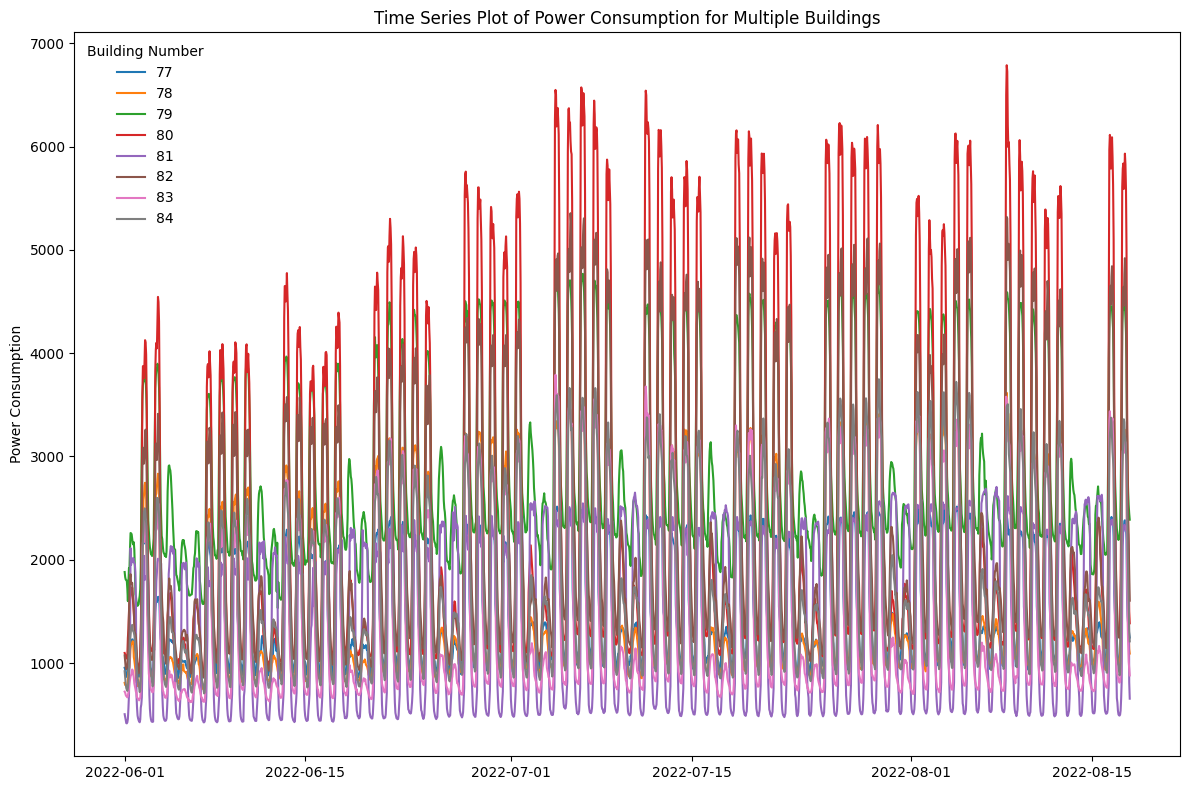

In [ ]:
import matplotlib.dates as mdates

building_numbers = dat1['building_number'].unique()

# 시계열 플롯 생성
plt.figure(figsize=(12, 8))

# 각 building_number에 대해 선 추가
for building in building_numbers:
    building_data = dat1[dat1['building_number'] == building]
    plt.plot(building_data['date_time'], building_data['power_consumption'], label=building)

# x축의 날짜 형식 설정
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# 플롯 설정
plt.title('Time Series Plot of Power Consumption for Multiple Buildings')
plt.ylabel('Power Consumption')
plt.legend(title='Building Number', frameon=False)
plt.tight_layout()  # 레이아웃 조정
plt.show()

In [ ]:
print(len(dat1[dat1['solar_power_capacity'] == '-']))
print(len(dat1[dat1['ess_capacity'] == '-']))
print(len(dat1[dat1['pcs_capacity'] == '-']))

14976
14976
14976


In [ ]:
dat1.isnull().sum()

building_number             0
date_time                   0
temperature                 0
rainfall                11762
windspeed                   0
humidity                    0
sunshine                 5655
solar_radiation          5655
power_consumption           0
building_type               0
total_area                  0
cooling_area                0
solar_power_capacity        0
ess_capacity                0
pcs_capacity                0
dtype: int64

In [ ]:
dat1 = dat1.drop(['solar_power_capacity', 'ess_capacity', 'pcs_capacity'], axis=1)

In [ ]:
dat1['date_time'] = pd.to_datetime(dat1['date_time'])

# date time feature 생성
dat1['hour'] = dat1['date_time'].dt.hour
dat1['day'] = dat1['date_time'].dt.day
dat1['month'] = dat1['date_time'].dt.month
dat1['year'] = dat1['date_time'].dt.year

# one hot encoding 생성
# dat1 = pd.get_dummies(dat1, columns=['building_type'], drop_first=True)

In [ ]:
# 년기준 일 평균 소비전력
dat1['day_of_year'] = dat1['date_time'].dt.dayofyear
mean_power_by_day_of_year = dat1.groupby('day_of_year')['power_consumption'].mean()
# 년기준 시간평균 소비전력
dat1['hour_of_year'] = dat1['date_time'].dt.hour + (dat1['date_time'].dt.dayofyear - 1) * 24
mean_power_by_hour_of_year = dat1.groupby('hour_of_year')['power_consumption'].mean()

# 년기준 월평균 소비전력
mean_power_by_month = dat1.groupby('month')['power_consumption'].mean()

# 일기준 시간 평균 소비전력
mean_power_by_hour = dat1.groupby('hour')['power_consumption'].mean()

# 월기준 시간 평균 소비전력
mean_power_by_day = dat1.groupby('day')['power_consumption'].mean()

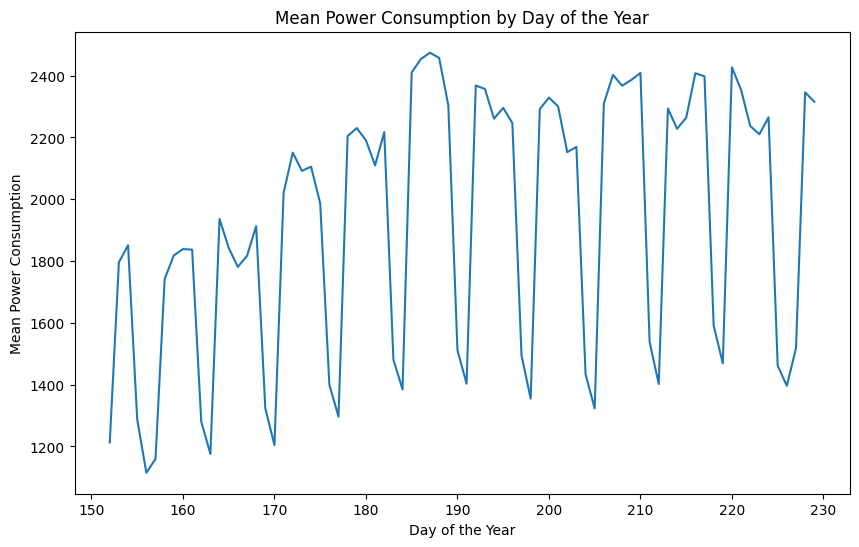

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=mean_power_by_day_of_year.index, y=mean_power_by_day_of_year.values)
plt.title('Mean Power Consumption by Day of the Year')
plt.xlabel('Day of the Year')
plt.ylabel('Mean Power Consumption')
plt.show()

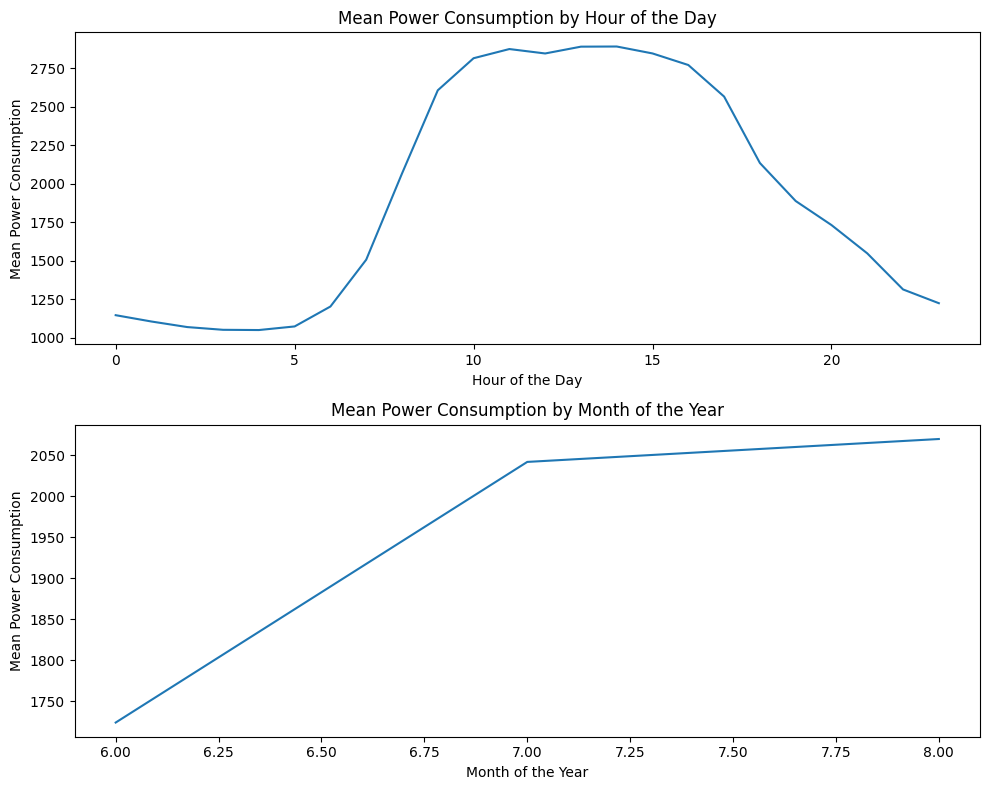

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot mean power consumption by hour of the day
sns.lineplot(x=mean_power_by_hour.index, y=mean_power_by_hour.values, ax=axs[0])
axs[0].set_title('Mean Power Consumption by Hour of the Day')
axs[0].set_xlabel('Hour of the Day')
axs[0].set_ylabel('Mean Power Consumption')

# 년기준 월평균 소비전력
sns.lineplot(x=mean_power_by_month.index, y=mean_power_by_month.values, ax=axs[1])
axs[1].set_title('Mean Power Consumption by Month of the Year')
axs[1].set_xlabel('Month of the Year')
axs[1].set_ylabel('Mean Power Consumption')

plt.tight_layout()
plt.show()

In [ ]:
dat1['day_of_week'] = dat1['date_time'].dt.dayofweek

# 요일별 전력평균
mean_power_by_day_of_week = dat1.groupby('day_of_week')['power_consumption'].mean()

# plt.figure(figsize=(10, 6))
# sns.barplot(x=mean_power_by_day_of_week.index, y=mean_power_by_day_of_week.values)
# plt.title('Mean Power Consumption by Day of the Week')
# plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
# plt.ylabel('Mean Power Consumption')
# plt.show()

# Parmameter Tuning - covariates

# Model3 - non-covariates tuning

In [ ]:
dat.shape

(16320, 15)

In [ ]:
nc = dat[['building_number', 'date_time', 'power_consumption']]

nc_tr = nc[nc['date_time'] <= '2022-08-17 23:00:00']
nc_te = nc[nc['date_time'] >= '2022-08-18 00:00:00']

In [ ]:
print(nc.shape)
print(nc_tr.shape)
print(nc_te.shape)

(16320, 3)
(14976, 3)
(1344, 3)


In [ ]:
train_nc = TimeSeriesDataFrame.from_data_frame(
    nc_tr,
    id_column = "building_number",
    timestamp_column = "date_time",
)
train_nc.head()

power_consumption
item_id timestamp                             
77      2022-06-01 00:00:00             954.00
        2022-06-01 01:00:00             934.56
        2022-06-01 02:00:00             873.72
        2022-06-01 03:00:00             865.80
        2022-06-01 04:00:00             887.40

In [ ]:
predictor = TimeSeriesPredictor(
    prediction_length = 168,
    path = "autogluon-energy-knowledge-high-nc",
    target = "power_consumption",
    eval_metric = "MSE",
)

predictor.fit(
    train_nc,
    presets = "high_quality",
    time_limit = 600
)

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'autogluon-energy-knowledge-high-nc'
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Apr 28 14:29:16 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       9.99 GB / 12.67 GB (78.8%)
Disk Space Avail:   74.08 GB / 107.72 GB (68.8%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 168,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'power_consumption',
 'time_limit': 600,
 'verbosity': 2}

Inferred time series frequency: 'H'
Provided train_dat

In [ ]:
predictions = predictor.predict(train_nc)
predictions.head()

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean          0.1          0.2  \
item_id timestamp                                                    
77      2022-08-18 00:00:00  1160.070698  1013.084996  1057.936790   
        2022-08-18 01:00:00  1105.674383   910.338534   971.805257   
        2022-08-18 02:00:00  1062.625708   830.244091   904.301444   
        2022-08-18 03:00:00  1050.183303   788.482011   871.082338   
        2022-08-18 04:00:00  1066.887348   777.465550   870.133460   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
77      2022-08-18 00:00:00  1092.852337  1123.458716  1160.392337   
        2022-08-18 01:00:00  1018.731864  1058.978670  1105.153218   
        2022-08-18 02:00:00   959.798349  1008.329919  1061.581717   
        2022-08-18 03:00:00   935.031907   988.576410  1047.294964   
        2022-08-18 04:00:00   940.601202  1000.388686  1064.993697   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
77      2022-08-18 00:00:00  1197.451944  1227.556908  1262.706624   
        2022-08-18 01:00:00  1151.058865  1191.568781  1238.993679   
        2022-08-18 02:00:00  1115.499822  1163.303710  1219.478582   
        2022-08-18 03:00:00  1107.379989  1162.524660  1225.633386   
        2022-08-18 04:00:00  1130.081695  1190.872050  1260.515432   

                                     0.9  
item_id timestamp                         
77      2022-08-18 00:00:00  1308.615021  
        2022-08-18 01:00:00  1301.182280  
        2022-08-18 02:00:00  1293.613061  
        2022-08-18 03:00:00  1309.492621  
        2022-08-18 04:00:00  1355.742809

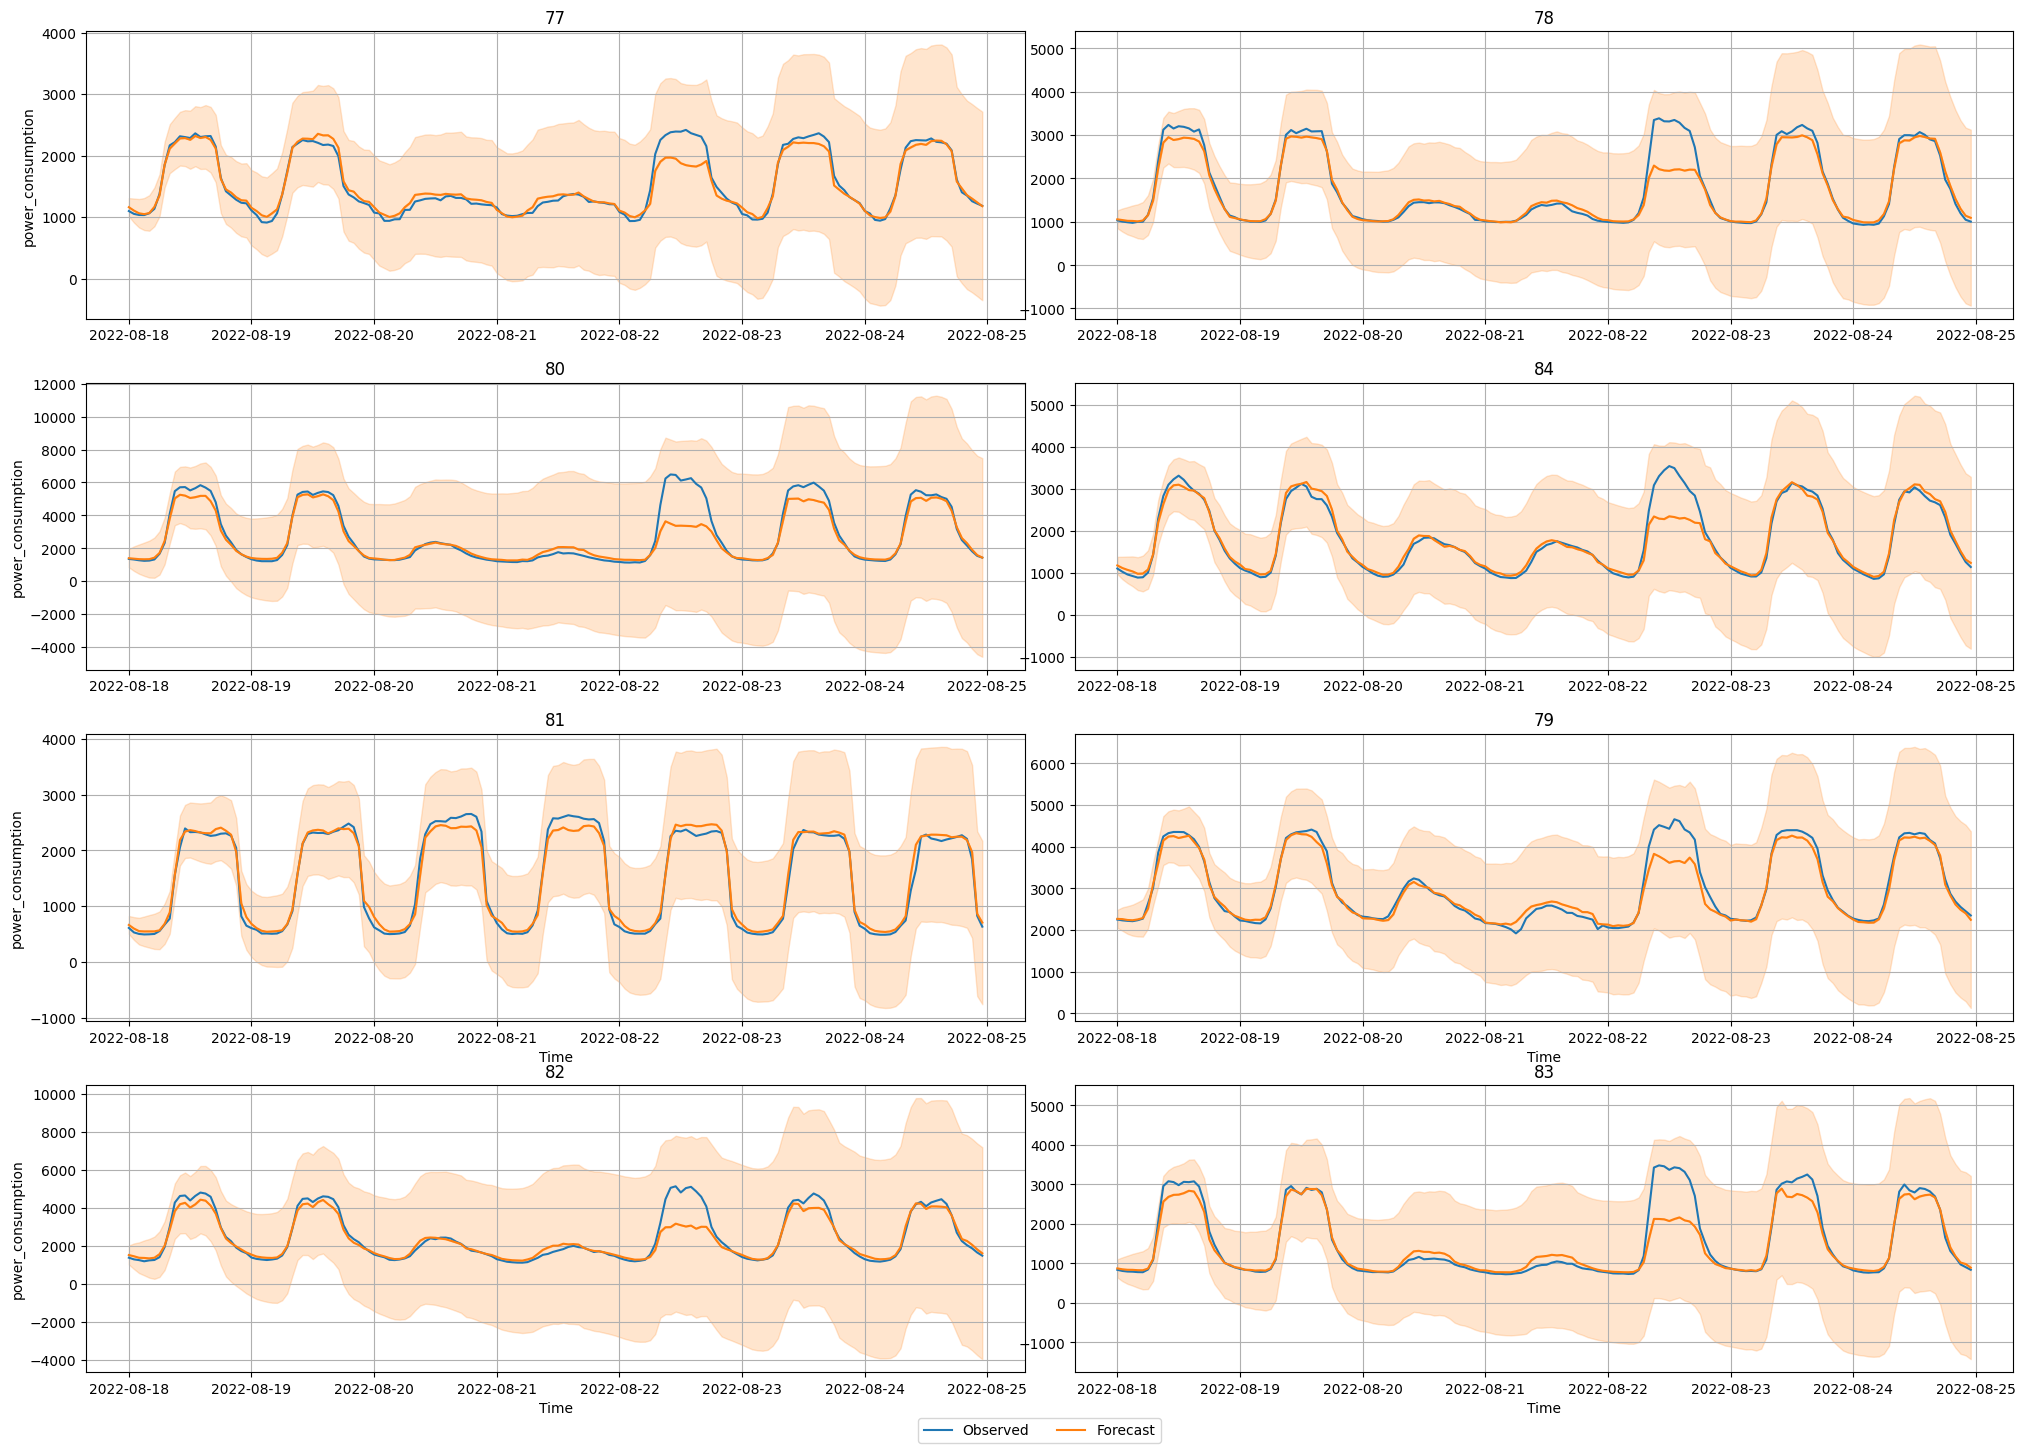

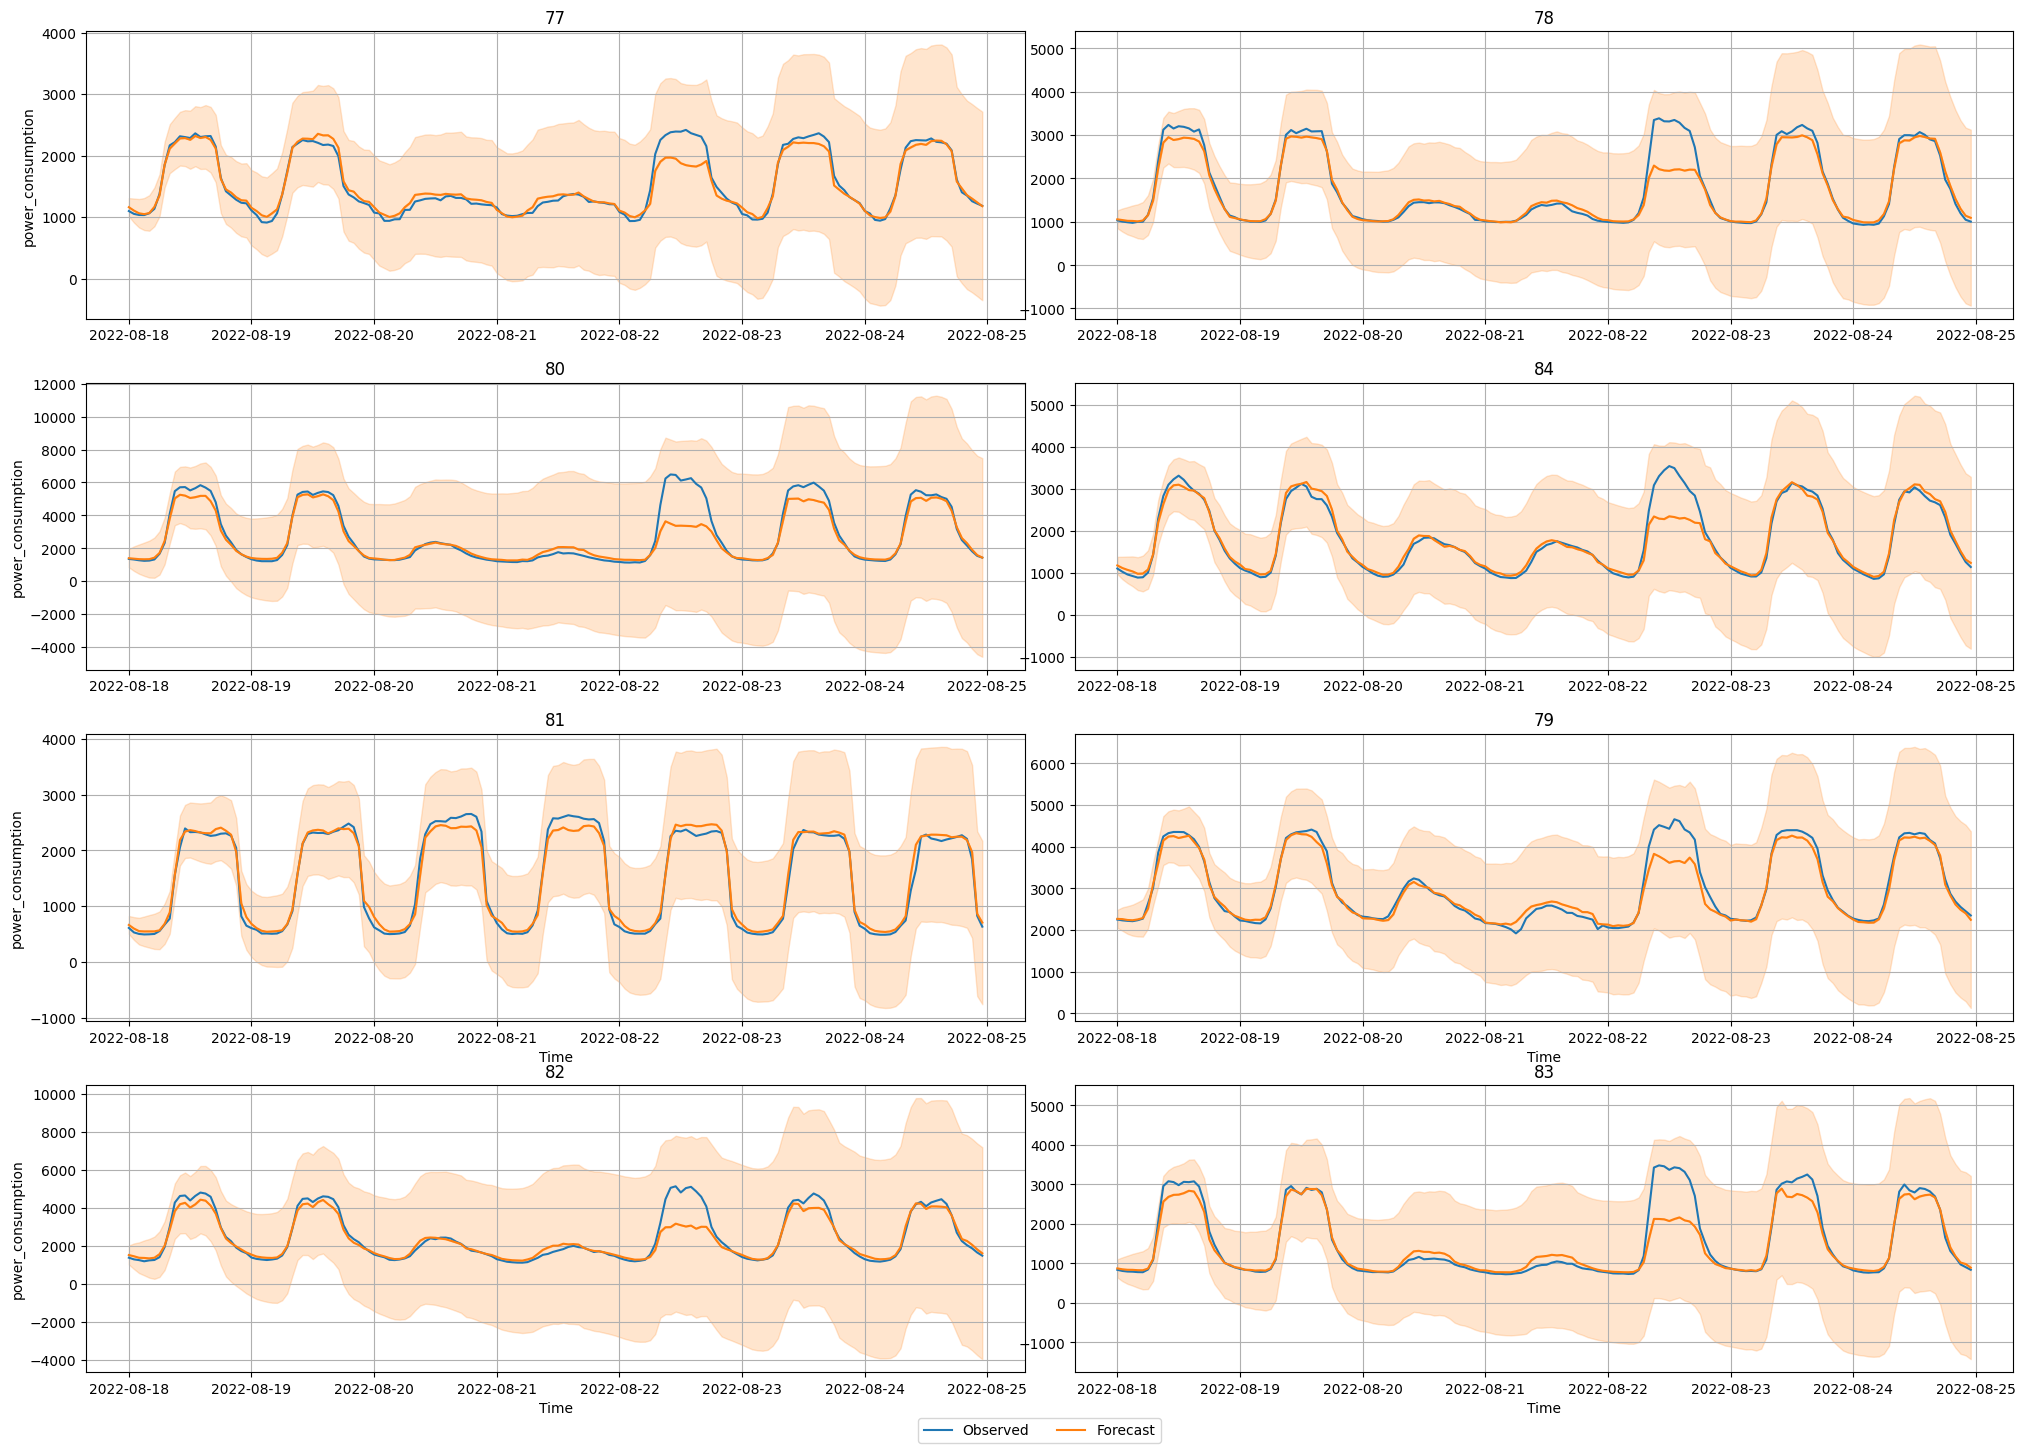

In [ ]:
test_nc = TimeSeriesDataFrame(
    nc_te,
    id_column = 'building_number',
    timestamp_column = 'date_time',
    )

predictor.plot(test_nc, predictions, quantile_levels=[0.1, 0.9], max_num_item_ids = 8)

In [ ]:
import numpy as np

actuals = test_nc.reset_index()[['item_id', 'timestamp', 'power_consumption']]
predicted = predictions.reset_index()[['item_id', 'timestamp', 'mean']]
merged_df = pd.merge(test_nc, predicted, on=['item_id', 'timestamp'])

# # MSPE 계산
merged_df['squared_error'] = (merged_df['power_consumption'] - merged_df['mean']) ** 2
mspe_value = np.mean(merged_df['squared_error'])

print(f"MSPE: {mspe_value}")

# MSPE를 CSV 파일로 저장
merged_df.to_csv('/content/drive/MyDrive/TimeSeries/mspe_nc.csv', index=False)

MSPE: 123324.3659812661


static: ['total_area', 'cooling_area']

time-varying: ['date of week', 'temperature', 'rainfall', 'windspeed', 'humidity', 'sunshine', 'solar_radiation']

# 조정할 covariates 정하기

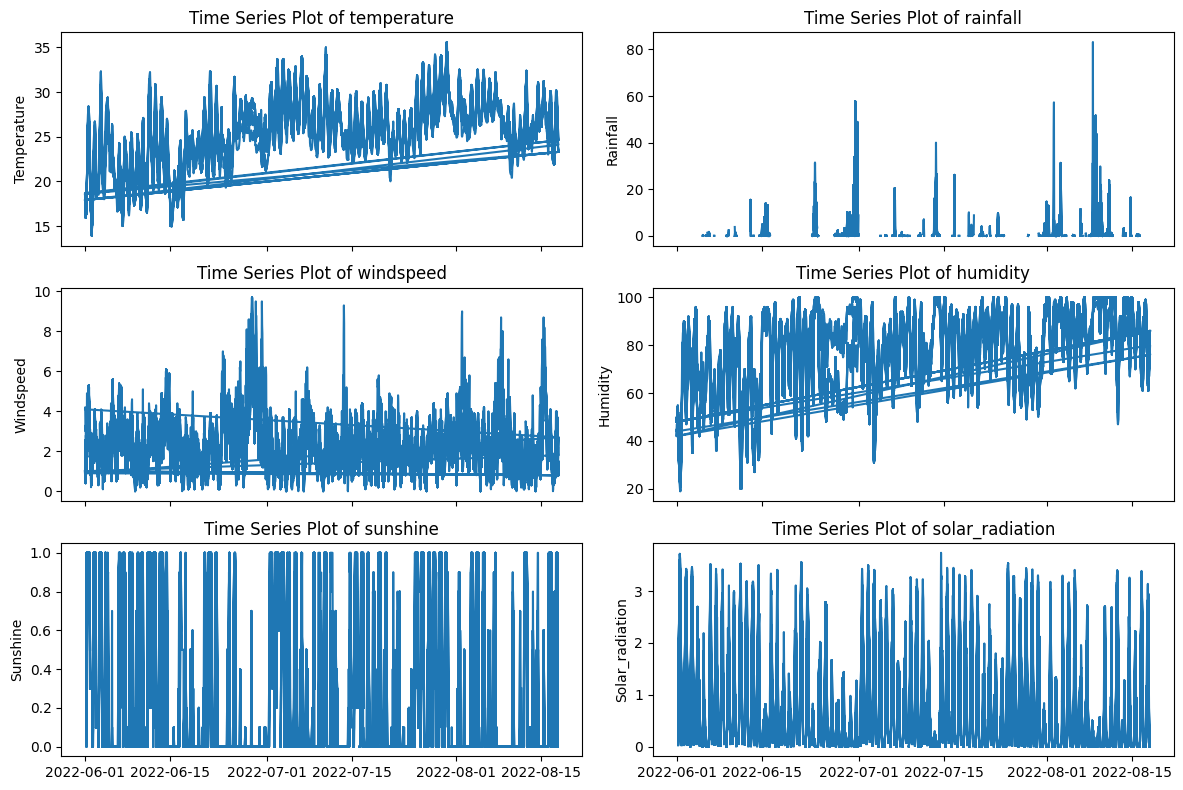

In [ ]:
columns = ['temperature', 'rainfall', 'windspeed', 'humidity', 'sunshine', 'solar_radiation']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 8), sharex=True)
axes = axes.flatten()

# 각 열에 대해 시계열 플롯 생성
for i, col in enumerate(columns):
    axes[i].plot(dat1['date_time'], dat1[col])
    axes[i].set_title(f'Time Series Plot of {col}')
    axes[i].set_ylabel(col.capitalize())

# 레이아웃 조정
plt.tight_layout()
plt.show()

## 데이터에 조정할 covariates 남기고 split


In [ ]:
dat.head(2)

building_number            date_time  temperature  rainfall  windspeed  \
0               77  2022-06-01 00:00:00         17.9       NaN        1.0   
1               77  2022-06-01 01:00:00         17.7       NaN        1.2   

   humidity  sunshine  solar_radiation  power_consumption  \
0      48.0       NaN              NaN             954.00   
1      50.0       NaN              NaN             934.56   

               building_type  total_area  cooling_area solar_power_capacity  \
0  Knowledge Industry Center    67377.14           1.0                    -   
1  Knowledge Industry Center    67377.14           1.0                    -   

  ess_capacity pcs_capacity  
0            -            -  
1            -            -

In [ ]:
dat2 = dat.drop(['solar_power_capacity', 'ess_capacity', 'pcs_capacity'], axis=1)

In [ ]:
dat2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16320 entries, 0 to 16319
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   building_number    16320 non-null  int64  
 1   date_time          16320 non-null  object 
 2   temperature        16320 non-null  float64
 3   rainfall           3402 non-null   float64
 4   windspeed          16320 non-null  float64
 5   humidity           16320 non-null  float64
 6   sunshine           10161 non-null  float64
 7   solar_radiation    10161 non-null  float64
 8   power_consumption  16320 non-null  float64
 9   building_type      16320 non-null  object 
 10  total_area         16320 non-null  float64
 11  cooling_area       16320 non-null  float64
dtypes: float64(9), int64(1), object(2)
memory usage: 1.5+ MB


In [ ]:
import holidays
from datetime import date

# 한국의 공휴일 설정
kr_holidays = holidays.KR(years=2022)

# 시작 날짜와 종료 날짜 설정
start_date = date(2022, 6, 1)
end_date = date(2022, 8, 24)

# 시작 날짜와 종료 날짜 사이의 공휴일을 찾기
for holiday_date, name in sorted(kr_holidays.items()):
    if start_date <= holiday_date <= end_date:
        print(holiday_date, name)


2022-06-01 Local Election Day
2022-06-06 Memorial Day
2022-08-15 Liberation Day


- 6/1 수 지방선거
- 6/6 월 현충일
- 7/17 일 제헌절
- 8/15 월 광복절
- 8/22 에너지의 날

In [ ]:
dat_tr = dat2[dat2['date_time'] <= '2022-08-17 23:00:00']
dat_te = dat2[dat2['date_time'] >= '2022-08-18 00:00:00']

dat_tr.tail(2)

building_number            date_time  temperature  rainfall  windspeed  \
16150               84  2022-08-17 22:00:00         23.3       NaN        1.5   
16151               84  2022-08-17 23:00:00         23.3       NaN        0.8   

       humidity  sunshine  solar_radiation  power_consumption  \
16150      86.0       NaN              NaN             1317.6   
16151      86.0       NaN              NaN             1209.6   

                   building_type  total_area  cooling_area  
16150  Knowledge Industry Center    174408.2      109973.1  
16151  Knowledge Industry Center    174408.2      109973.1

In [ ]:
dat_te.head(2)

building_number            date_time  temperature  rainfall  windspeed  \
1872               77  2022-08-18 00:00:00         23.3       NaN        0.5   
1873               77  2022-08-18 01:00:00         23.4       NaN        1.0   

      humidity  sunshine  solar_radiation  power_consumption  \
1872      89.0       NaN              NaN            1097.64   
1873      89.0       NaN              NaN            1051.56   

                  building_type  total_area  cooling_area  
1872  Knowledge Industry Center    67377.14           1.0  
1873  Knowledge Industry Center    67377.14           1.0

# Model 4 - covariates 모델링

## static, time-varying covariates(holidays 추가) 넣기

In [ ]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

print("지식산업센터", dat2.shape)
print("Train 데이터", dat_tr.shape)
print("Test 데이터", dat_te.shape)

지식산업센터 (16320, 12)
Train 데이터 (14976, 12)
Test 데이터 (1344, 12)


In [ ]:
static_features_df1 = building_info[['building_number', 'total_area', 'cooling_area']]
static_features_df1.head()

building_number  total_area  cooling_area
0                1   110634.00      39570.00
1                2   122233.47      99000.00
2                3   171243.00     113950.00
3                4    74312.98      34419.62
4                5   205884.00     150000.00

In [ ]:
train_data = TimeSeriesDataFrame.from_data_frame(
    dat_tr,
    id_column = "building_number",
    timestamp_column = "date_time",
    static_features_df = static_features_df1,
)
train_data.head()

/usr/local/lib/python3.10/dist-packages/autogluon/timeseries/dataset/ts_dataframe.py:442: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  static_features.rename(columns={id_column: ITEMID}, inplace=True)


temperature  rainfall  windspeed  humidity  \
item_id timestamp                                                         
77      2022-06-01 00:00:00         17.9       NaN        1.0      48.0   
        2022-06-01 01:00:00         17.7       NaN        1.2      50.0   
        2022-06-01 02:00:00         17.5       NaN        1.7      49.0   
        2022-06-01 03:00:00         15.9       NaN        0.4      54.0   
        2022-06-01 04:00:00         16.6       NaN        2.6      53.0   

                             sunshine  solar_radiation  power_consumption  \
item_id timestamp                                                           
77      2022-06-01 00:00:00       NaN              NaN             954.00   
        2022-06-01 01:00:00       NaN              NaN             934.56   
        2022-06-01 02:00:00       NaN              NaN             873.72   
        2022-06-01 03:00:00       NaN              NaN             865.80   
        2022-06-01 04:00:00       NaN              NaN             887.40   

                                         building_type  total_area  \
item_id timestamp                                                    
77      2022-06-01 00:00:00  Knowledge Industry Center    67377.14   
        2022-06-01 01:00:00  Knowledge Industry Center    67377.14   
        2022-06-01 02:00:00  Knowledge Industry Center    67377.14   
        2022-06-01 03:00:00  Knowledge Industry Center    67377.14   
        2022-06-01 04:00:00  Knowledge Industry Center    67377.14   

                             cooling_area  
item_id timestamp                          
77      2022-06-01 00:00:00           1.0  
        2022-06-01 01:00:00           1.0  
        2022-06-01 02:00:00           1.0  
        2022-06-01 03:00:00           1.0  
        2022-06-01 04:00:00           1.0

In [ ]:
train_data.static_features.head()

total_area  cooling_area
item_id                          
77         67377.14          1.00
78        136921.00      71771.00
79        212995.84     103115.37
80        256370.24        239.00
81        115358.28      65020.94

In [ ]:
WEEKEND_INDICES = [5, 6]
timestamps = train_data.index.get_level_values("timestamp")
train_data["weekend"] = timestamps.weekday.isin(WEEKEND_INDICES).astype(float)

In [ ]:
train_data.head(2)

temperature  rainfall  windspeed  humidity  \
item_id timestamp                                                         
77      2022-06-01 00:00:00         17.9       NaN        1.0      48.0   
        2022-06-01 01:00:00         17.7       NaN        1.2      50.0   

                             sunshine  solar_radiation  power_consumption  \
item_id timestamp                                                           
77      2022-06-01 00:00:00       NaN              NaN             954.00   
        2022-06-01 01:00:00       NaN              NaN             934.56   

                                         building_type  total_area  \
item_id timestamp                                                    
77      2022-06-01 00:00:00  Knowledge Industry Center    67377.14   
        2022-06-01 01:00:00  Knowledge Industry Center    67377.14   

                             cooling_area  weekend  
item_id timestamp                                   
77      2022-06-01 00:00:00           1.0      0.0  
        2022-06-01 01:00:00           1.0      0.0

In [ ]:
def add_holiday_features(
    ts_df: TimeSeriesDataFrame,
    country_holidays: dict,
    include_individual_holidays: bool = True,
    include_holiday_indicator: bool = True,
) -> TimeSeriesDataFrame:
    """Add holiday indicator columns to a TimeSeriesDataFrame."""
    ts_df = ts_df.copy()
    timestamps = ts_df.index.get_level_values("timestamp")
    country_holidays_df = pd.get_dummies(pd.Series(country_holidays)).astype(float)
    holidays_df = country_holidays_df.reindex(timestamps.date).fillna(0)
    if include_individual_holidays:
        ts_df[holidays_df.columns] = holidays_df.values
    if include_holiday_indicator:
        ts_df["Holiday"] = holidays_df.max(axis=1).values
    return ts_df

In [ ]:
train_data_with_holidays = add_holiday_features(train_data, kr_holidays)
train_data_with_holidays.head(1)

temperature  rainfall  windspeed  humidity  sunshine  \
item_id timestamp                                                          
77      2022-06-01         17.9       NaN        1.0      48.0       NaN   

                    solar_radiation  power_consumption  \
item_id timestamp                                        
77      2022-06-01              NaN              954.0   

                                building_type  total_area  cooling_area  ...  \
item_id timestamp                                                        ...   
77      2022-06-01  Knowledge Industry Center    67377.14           1.0  ...   

                    Local Election Day  Memorial Day  National Foundation Day  \
item_id timestamp                                                               
77      2022-06-01                 1.0           0.0                      0.0   

                    New Year's Day  Presidential Election Day  \
item_id timestamp                                               
77      2022-06-01             0.0                        0.0   

                    The day preceding Chuseok  \
item_id timestamp                               
77      2022-06-01                        0.0   

                    The day preceding Korean New Year  \
item_id timestamp                                       
77      2022-06-01                                0.0   

                    The second day of Chuseok  \
item_id timestamp                               
77      2022-06-01                        0.0   

                    The second day of Korean New Year  Holiday  
item_id timestamp                                               
77      2022-06-01                                0.0      1.0  

[1 rows x 31 columns]

In [ ]:
holiday_columns = train_data_with_holidays.columns.difference(train_data.columns)

In [ ]:
static_features_df1 = building_info[['building_number', 'total_area', 'cooling_area']]
static_features_df1.shape

(100, 3)

In [ ]:
test_data = TimeSeriesDataFrame.from_data_frame(
    dat_te,
    id_column = "building_number",
    timestamp_column = "date_time",
    static_features_df = static_features_df1,
)
test_data.head()

/usr/local/lib/python3.10/dist-packages/autogluon/timeseries/dataset/ts_dataframe.py:442: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  static_features.rename(columns={id_column: ITEMID}, inplace=True)


temperature  rainfall  windspeed  humidity  \
item_id timestamp                                                         
77      2022-08-18 00:00:00         23.3       NaN        0.5      89.0   
        2022-08-18 01:00:00         23.4       NaN        1.0      89.0   
        2022-08-18 02:00:00         23.3       NaN        1.0      90.0   
        2022-08-18 03:00:00         21.9       NaN        1.3      96.0   
        2022-08-18 04:00:00         22.2       NaN        1.0      96.0   

                             sunshine  solar_radiation  power_consumption  \
item_id timestamp                                                           
77      2022-08-18 00:00:00       NaN              NaN            1097.64   
        2022-08-18 01:00:00       NaN              NaN            1051.56   
        2022-08-18 02:00:00       NaN              NaN            1033.92   
        2022-08-18 03:00:00       NaN              NaN            1032.48   
        2022-08-18 04:00:00       NaN              NaN            1062.72   

                                         building_type  total_area  \
item_id timestamp                                                    
77      2022-08-18 00:00:00  Knowledge Industry Center    67377.14   
        2022-08-18 01:00:00  Knowledge Industry Center    67377.14   
        2022-08-18 02:00:00  Knowledge Industry Center    67377.14   
        2022-08-18 03:00:00  Knowledge Industry Center    67377.14   
        2022-08-18 04:00:00  Knowledge Industry Center    67377.14   

                             cooling_area  
item_id timestamp                          
77      2022-08-18 00:00:00           1.0  
        2022-08-18 01:00:00           1.0  
        2022-08-18 02:00:00           1.0  
        2022-08-18 03:00:00           1.0  
        2022-08-18 04:00:00           1.0

In [ ]:
test_data_with_holidays = add_holiday_features(test_data, kr_holidays)

## 결과

In [ ]:
train_data_with_holidays.shape

(14976, 31)

In [ ]:
train_data_with_holidays.info()

<class 'autogluon.timeseries.dataset.ts_dataframe.TimeSeriesDataFrame'>
MultiIndex: 14976 entries, (77, Timestamp('2022-06-01 00:00:00')) to (84, Timestamp('2022-08-17 23:00:00'))
Data columns (total 31 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   temperature                         14976 non-null  float64
 1   rainfall                            3214 non-null   float64
 2   windspeed                           14976 non-null  float64
 3   humidity                            14976 non-null  float64
 4   sunshine                            9321 non-null   float64
 5   solar_radiation                     9321 non-null   float64
 6   power_consumption                   14976 non-null  float64
 7   building_type                       14976 non-null  object 
 8   total_area                          14976 non-null  float64
 9   cooling_area                        14976 non-null  float64
 10  we

In [ ]:
# train_data_with_holidays에서 holiday_columns를 추출
holiday_columns = train_data_with_holidays.columns.difference(train_data.columns)

# holiday_columns에서 'weekend' 접두사를 제거
cleaned_holiday_columns = [col.replace('weekend', '') for col in holiday_columns]

# 'weekend'와 결합하여 known_covariates_names를 생성
known_covariates_names = cleaned_holiday_columns + ['weekend']


predictor = TimeSeriesPredictor(
    prediction_length = 168,
    path = "autogluon-energy-knowledge-3600-high-holidays",
    target = "power_consumption",
    eval_metric = "MSE",
    known_covariates_names = known_covariates_names
)

predictor.fit(
    train_data_with_holidays,
    presets = "high_quality",
    time_limit = 3600
)

Beginning AutoGluon training... Time limit = 3600s
AutoGluon will save models to 'autogluon-energy-knowledge-3600-high-holidays'
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Apr 28 14:29:16 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.62 GB / 12.67 GB (83.8%)
Disk Space Avail:   74.10 GB / 107.72 GB (68.8%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MSE,
 'hyperparameters': 'default',
 'known_covariates_names': ['Alternative holiday for Chuseok',
                            'Alternative holiday for Hangul Day',
                            "Buddha's Birthday",
                            "Children's Day",
                            'Christmas Day',
                            'Chuseok',
                            'Hangul Day',
             

In [ ]:
from autogluon.timeseries.utils.forecast import get_forecast_horizon_index_ts_dataframe

future_index = get_forecast_horizon_index_ts_dataframe(train_data_with_holidays, prediction_length=168)
future_timestamps = future_index.get_level_values("timestamp")
known_covariates["weekend"] = future_timestamps.weekday.isin(WEEKEND_INDICES).astype(float)
known_covariates = add_holiday_features(known_covariates, kr_holidays)

known_covariates.head()

Alternative holiday for Chuseok  \
item_id timestamp                                              
77      2022-08-18 00:00:00                              0.0   
        2022-08-18 01:00:00                              0.0   
        2022-08-18 02:00:00                              0.0   
        2022-08-18 03:00:00                              0.0   
        2022-08-18 04:00:00                              0.0   

                             Alternative holiday for Hangul Day  \
item_id timestamp                                                 
77      2022-08-18 00:00:00                                 0.0   
        2022-08-18 01:00:00                                 0.0   
        2022-08-18 02:00:00                                 0.0   
        2022-08-18 03:00:00                                 0.0   
        2022-08-18 04:00:00                                 0.0   

                             Buddha's Birthday  Children's Day  Christmas Day  \
item_id timestamp                                                               
77      2022-08-18 00:00:00                0.0             0.0            0.0   
        2022-08-18 01:00:00                0.0             0.0            0.0   
        2022-08-18 02:00:00                0.0             0.0            0.0   
        2022-08-18 03:00:00                0.0             0.0            0.0   
        2022-08-18 04:00:00                0.0             0.0            0.0   

                             Chuseok  Hangul Day  Independence Movement Day  \
item_id timestamp                                                             
77      2022-08-18 00:00:00      0.0         0.0                        0.0   
        2022-08-18 01:00:00      0.0         0.0                        0.0   
        2022-08-18 02:00:00      0.0         0.0                        0.0   
        2022-08-18 03:00:00      0.0         0.0                        0.0   
        2022-08-18 04:00:00      0.0         0.0                        0.0   

                             Korean New Year  Liberation Day  ...  \
item_id timestamp                                             ...   
77      2022-08-18 00:00:00              0.0             0.0  ...   
        2022-08-18 01:00:00              0.0             0.0  ...   
        2022-08-18 02:00:00              0.0             0.0  ...   
        2022-08-18 03:00:00              0.0             0.0  ...   
        2022-08-18 04:00:00              0.0             0.0  ...   

                             Memorial Day  National Foundation Day  \
item_id timestamp                                                    
77      2022-08-18 00:00:00           0.0                      0.0   
        2022-08-18 01:00:00           0.0                      0.0   
        2022-08-18 02:00:00           0.0                      0.0   
        2022-08-18 03:00:00           0.0                      0.0   
        2022-08-18 04:00:00           0.0                      0.0   

                             New Year's Day  Presidential Election Day  \
item_id timestamp                                                        
77      2022-08-18 00:00:00             0.0                        0.0   
        2022-08-18 01:00:00             0.0                        0.0   
        2022-08-18 02:00:00             0.0                        0.0   
        2022-08-18 03:00:00             0.0                        0.0   
        2022-08-18 04:00:00             0.0                        0.0   

                             The day preceding Chuseok  \
item_id timestamp                                        
77      2022-08-18 00:00:00                        0.0   
        2022-08-18 01:00:00                        0.0   
        2022-08-18 02:00:00                        0.0   
        2022-08-18 03:00:00                        0.0   
        2022-08-18 04:00:00                        0.0   

                             The day preceding Korean New Year  \
item_id timestamp    

In [ ]:
predictions = predictor.predict(train_data_with_holidays, known_covariates=known_covariates)
predictions.head(2)

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean          0.1          0.2  \
item_id timestamp                                                    
77      2022-08-18 00:00:00  1132.310404  1005.727917  1038.148091   
        2022-08-18 01:00:00  1065.344265   913.015396   954.277883   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
77      2022-08-18 00:00:00  1066.819794  1091.481571  1132.386912   
        2022-08-18 01:00:00   989.332776  1019.300681  1065.220294   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
77      2022-08-18 00:00:00  1173.322201  1197.864723  1226.592121   
        2022-08-18 01:00:00  1111.075937  1141.106420  1176.279826   

                                     0.9  
item_id timestamp                         
77      2022-08-18 00:00:00  1259.263608  
        2022-08-18 01:00:00  1217.714017

<Figure size 1200x1000 with 0 Axes>

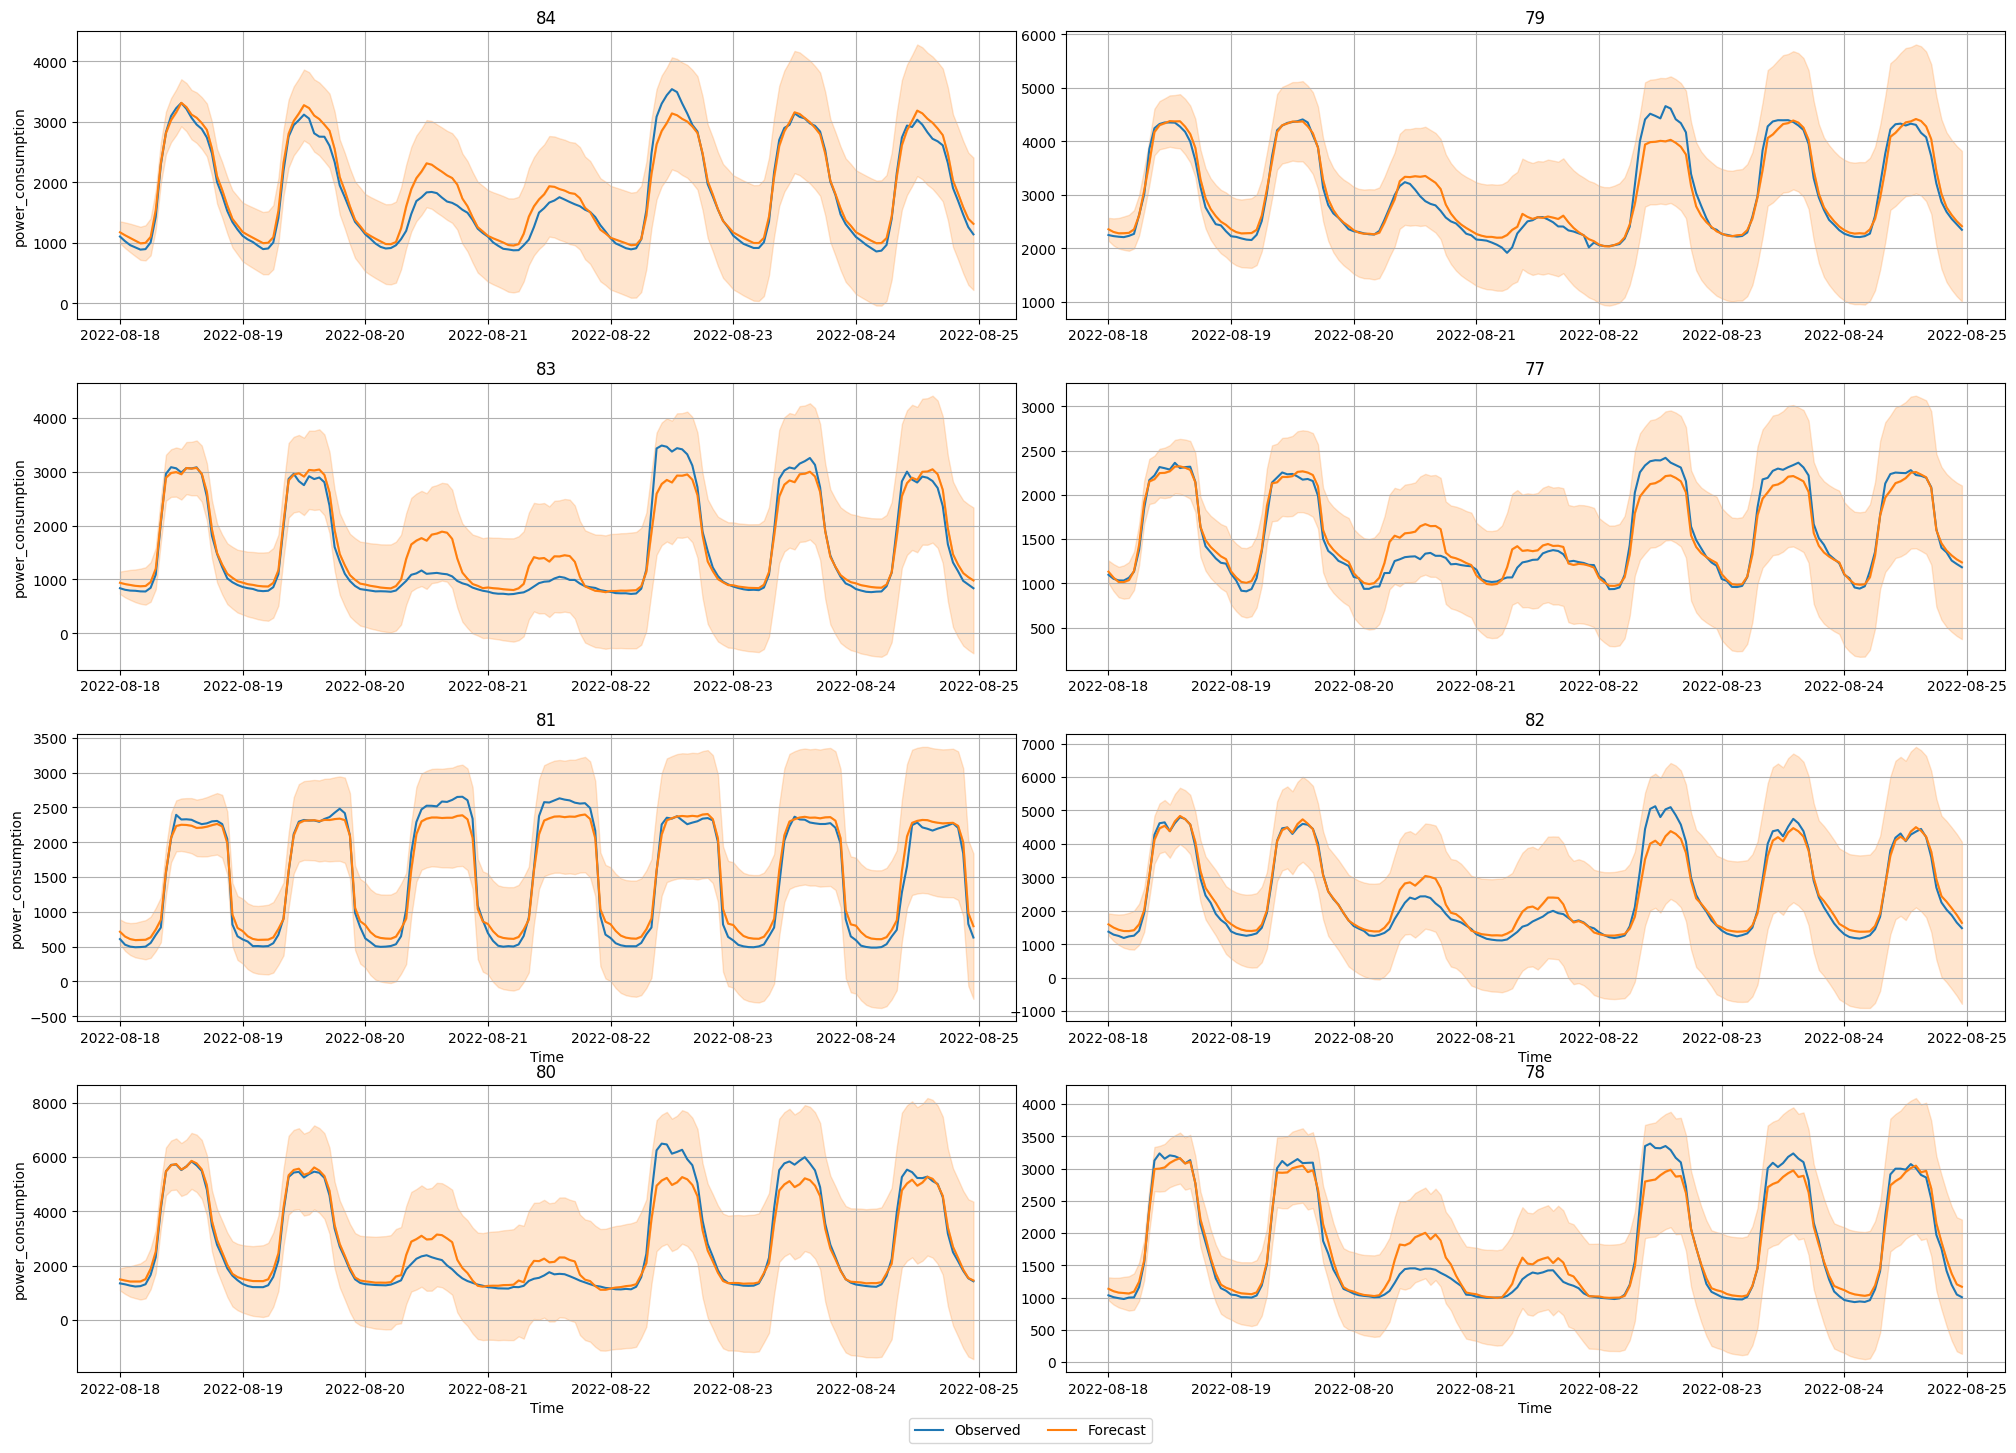

In [ ]:
plt.figure(figsize=(12, 10))
predictor.plot(test_data_with_holidays, predictions, quantile_levels=[0.1, 0.9], max_num_item_ids = 8)
plt.show()

In [ ]:
import numpy as np

actuals = test_data_with_holidays.reset_index()[['item_id', 'timestamp', 'power_consumption']]
predicted = predictions.reset_index()[['item_id', 'timestamp', 'mean']]
merged_df = pd.merge(test_data_with_holidays, predicted, on=['item_id', 'timestamp'])

# MSPE 계산
merged_df['squared_error'] = (merged_df['power_consumption'] - merged_df['mean']) ** 2
mspe_value = np.mean(merged_df['squared_error'])

print(f"MSPE: {mspe_value}")

# MSPE를 CSV 파일로 저장
merged_df.to_csv('/content/drive/MyDrive/TimeSeries/mspe_holidays.csv', index=False)

MSPE: 56824.39280830474


# [9, 65] EDA

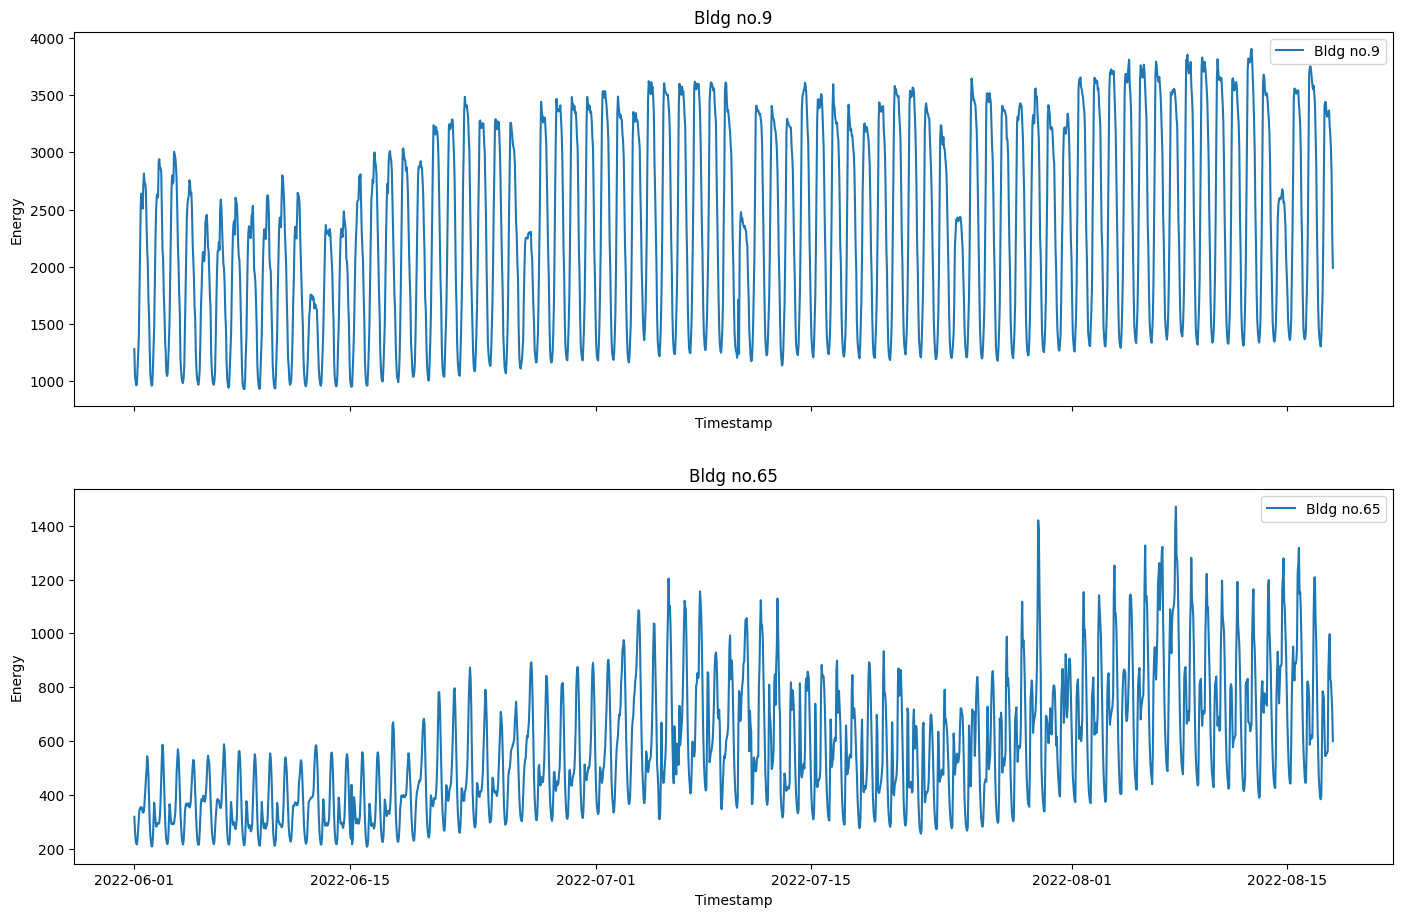

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10), sharex=True)

# 플롯 간 간격을 조정합니다.
fig.tight_layout(pad = 5.0)

# 각 item_id에 대해 서브플롯을 그립니다.
item_ids = [9, 65]
axes = axes.flatten()  # 2D 배열을 1D 배열로 변환합니다.

for ax, item_id in zip(axes, item_ids):
    subset = train_data[train_data['item_id'] == item_id]
    ax.plot(subset['timestamp'], subset['target'], label=f'Bldg no.{item_id}')
    ax.set_title(f'Bldg no.{item_id}')
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Energy')
    ax.legend()

plt.show()

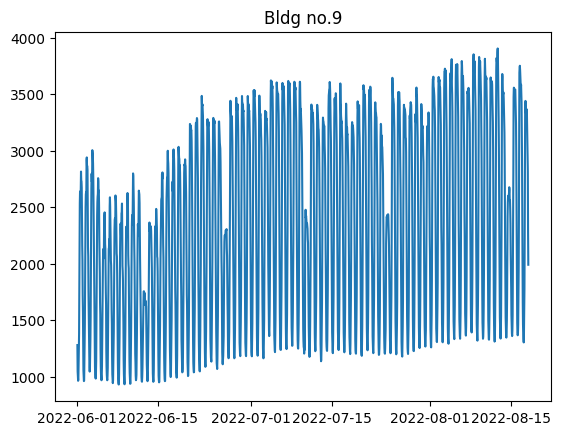

<Figure size 2500x3000 with 0 Axes>

In [ ]:
item_id = 9
subset = train_data[train_data['item_id'] == item_id]
plt.plot(subset['timestamp'], subset['target'], label=f'Bldg no.{item_id}')
plt.title(f'Bldg no.{item_id}')
plt.figure(figsize=(25,30))
plt.show()

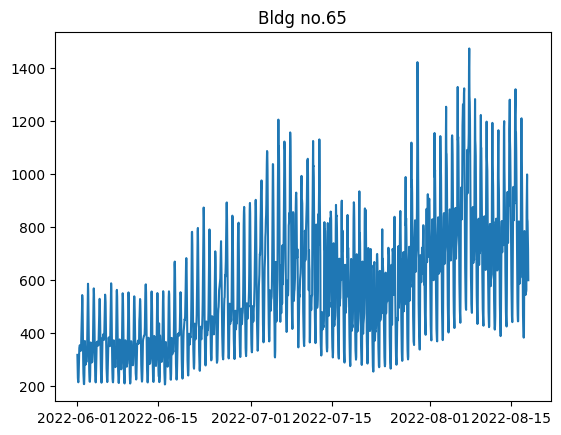

<Figure size 2500x3000 with 0 Axes>

In [ ]:
item_id = 65
subset = train_data[train_data['item_id'] == item_id]
plt.plot(subset['timestamp'], subset['target'], label=f'Bldg no.{item_id}')
plt.title(f'Bldg no.{item_id}')
plt.figure(figsize=(25,30))
plt.show()

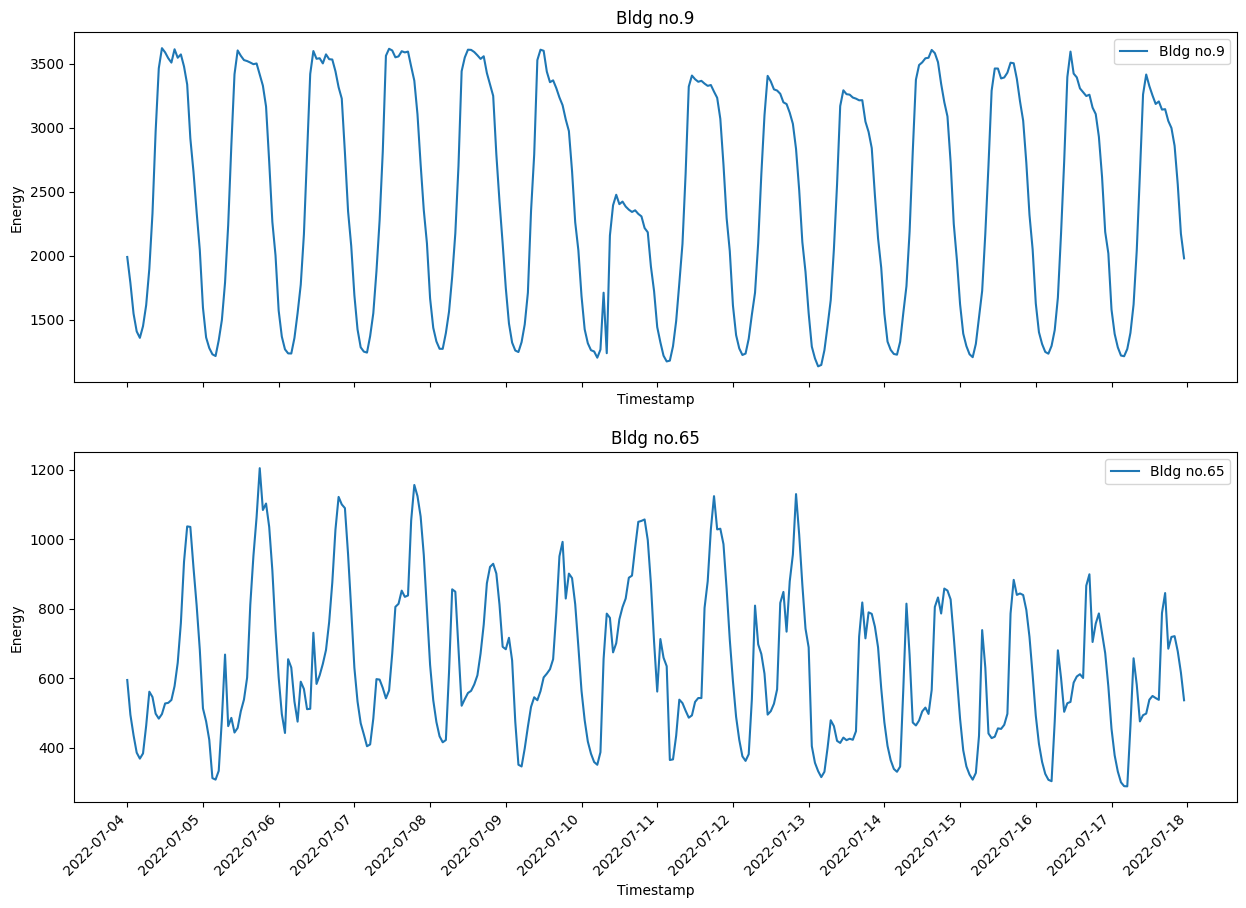

In [ ]:
# For details

start_date = '2022-07-04 00:00:00'
end_date = '2022-07-17 23:00:00'
mask = (train_data['timestamp'] >= start_date) & (train_data['timestamp'] <= end_date)
filtered_df = train_data[mask]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10), sharex=True)

item_ids = [9, 65]
axes = axes.flatten()

for ax, item_id in zip(axes, item_ids):
    subset = filtered_df[filtered_df['item_id'] == item_id]
    ax.plot(subset['timestamp'], subset['target'], label=f'Bldg no.{item_id}')
    ax.set_title(f'Bldg no.{item_id}')
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Energy')
    ax.legend()

    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.show()

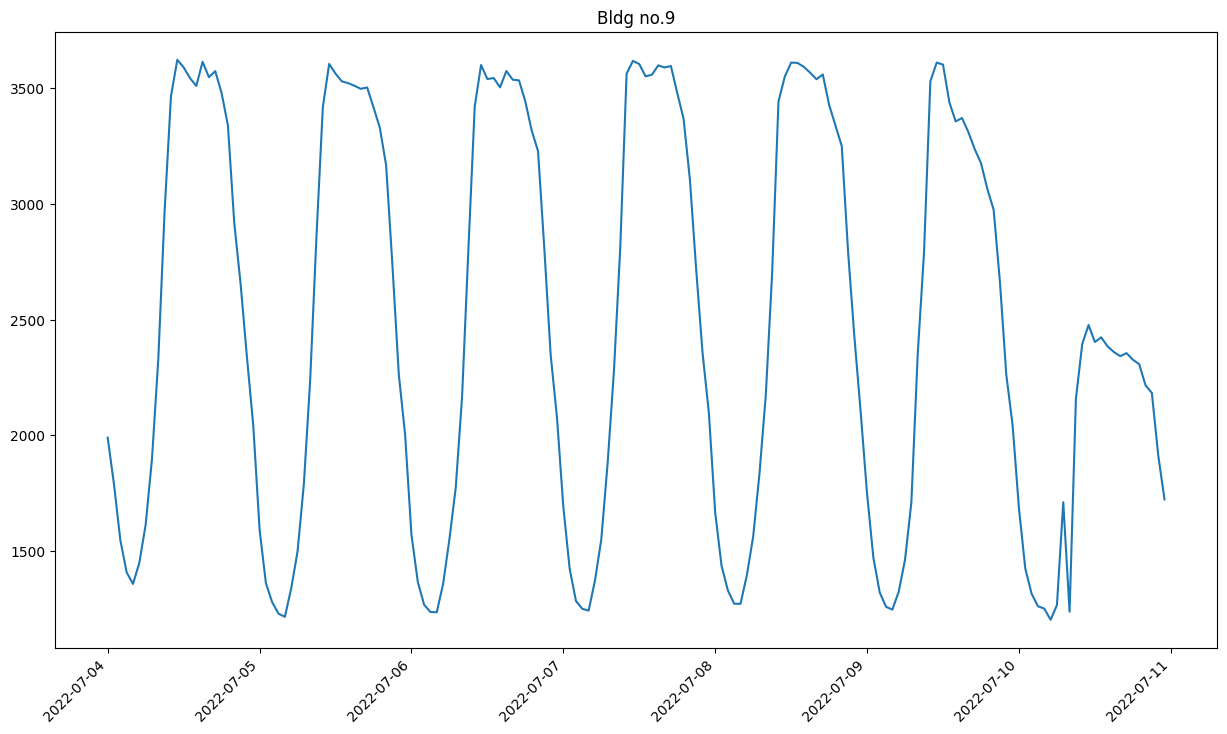

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 필터링된 데이터프레임
start_date = '2022-07-04 00:00:00'
end_date = '2022-07-10 23:00:00'
mask = (train_data['timestamp'] >= start_date) & (train_data['timestamp'] <= end_date)
filtered_df = train_data[mask]

# item_id 리스트
item_ids = [9]

for item_id in item_ids:
    subset = filtered_df[filtered_df['item_id'] == item_id]

    fig, ax = plt.subplots(figsize=(15, 8))

    ax.plot(subset['timestamp'], subset['target'], label=f'Bldg no.{item_id}')
    ax.set_title(f'Bldg no.{item_id}')

    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    plt.show()

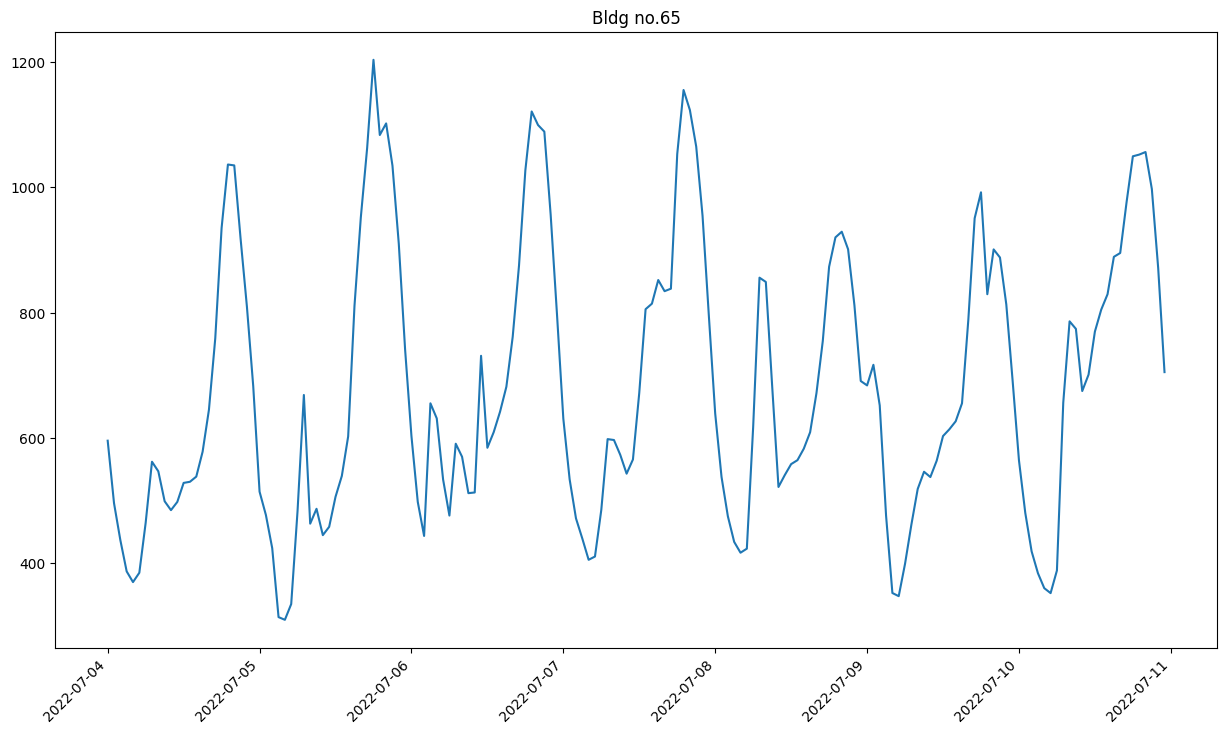

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 필터링된 데이터프레임
start_date = '2022-07-04 00:00:00'
end_date = '2022-07-10 23:00:00'
mask = (train_data['timestamp'] >= start_date) & (train_data['timestamp'] <= end_date)
filtered_df = train_data[mask]

# item_id 리스트
item_ids = [65]

for item_id in item_ids:
    subset = filtered_df[filtered_df['item_id'] == item_id]

    fig, ax = plt.subplots(figsize=(15, 8))

    ax.plot(subset['timestamp'], subset['target'], label=f'Bldg no.{item_id}')
    ax.set_title(f'Bldg no.{item_id}')

    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    plt.show()

ACF, PACF

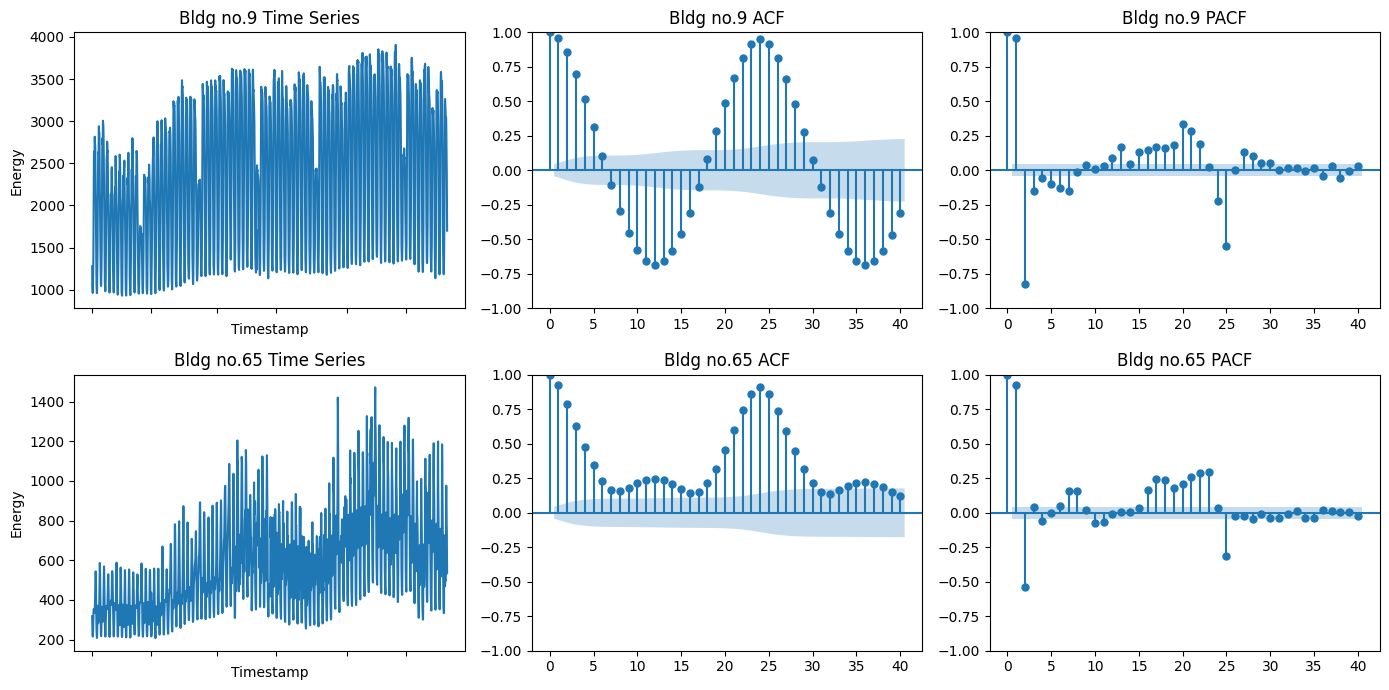

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 7))

item_ids = [9, 65]

for i, item_id in enumerate(item_ids):
    subset = data[data['item_id'] == item_id]

    # 시계열 플롯
    axes[i, 0].plot(subset['timestamp'], subset['target'])
    axes[i, 0].set_title(f'Bldg no.{item_id} Time Series')
    axes[i, 0].set_xlabel('Timestamp')
    axes[i, 0].set_ylabel('Energy')
    axes[i, 0].set_xticklabels([])

    # ACF 플롯
    sm.graphics.tsa.plot_acf(subset['target'], lags=40, ax=axes[i, 1])
    axes[i, 1].set_title(f'Bldg no.{item_id} ACF')

    # PACF 플롯
    sm.graphics.tsa.plot_pacf(subset['target'], lags=40, ax=axes[i, 2])
    axes[i, 2].set_title(f'Bldg no.{item_id} PACF')

plt.tight_layout()
plt.show()